Imports & loading data

In [2]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [34]:
with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_FEMALE_1610_1.json', 'r') as file:
    female_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_MALE_1610_1.json', 'r') as file:
    male_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_NEUT_1610_1.json', 'r') as file:
    neutral_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_Meta-Llama-2-7B_incremental_FEMALE_1610_1.json', 'r') as file:
    female_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_Meta-Llama-2-7B_incremental_MALE_1610_1.json', 'r') as file:
    male_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_Meta-Llama-2-7B_incremental_NEUT_1610_1.json', 'r') as file:
    neutral_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis_master/results/rq2/adjective_probabilities_Meta-Llama-2-7B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model2 = json.load(file)


Aggregating data

In [35]:
def aggregate_data(data, gender, model):
    aggregated_data = []

    for prompt, adjectives in data.items():
        for adjective, details in adjectives.items():
            aggregated_data.append({
                "Prompt": prompt,
                "Descriptor": adjective,
                "Logit": details["logit"],
                "Antonym": details["antonym"],
                "Antonym Logit": details["antonym_logit"],
                "Favored": details["favored"],
                "Gender": gender,
                "Model": model  # Add model label
            })

    return aggregated_data

# Aggregate data for each gender and model
female_aggregated_model1 = aggregate_data(female_data_model1, "Female", "LLaMA-3-8b")
male_aggregated_model1 = aggregate_data(male_data_model1, "Male", "LLaMA-3-8b")
neutral_aggregated_model1 = aggregate_data(neutral_data_model1, "Neutral", "LLaMA-3-8b")

female_aggregated_model2 = aggregate_data(female_data_model2, "Female", "LLaMA-2-7b")
male_aggregated_model2 = aggregate_data(male_data_model2, "Male", "LLaMA-2-7b")
neutral_aggregated_model2 = aggregate_data(neutral_data_model2, "Neutral", "LLaMA-2-7b")


# Combine all aggregated data into a single list
all_data = (female_aggregated_model1 + male_aggregated_model1 + neutral_aggregated_model1 +
            female_aggregated_model2 + male_aggregated_model2 + neutral_aggregated_model2)

# Create a DataFrame from the aggregated data
df = pd.DataFrame(all_data)

# List of diagnoses
diagnoses = [
    "schizophrenia", 
    "depression", 
    "generalised anxiety disorder", 
    "bipolar disorder", 
    "borderline personality disorder", 
    "a mental illness", 
    "antisocial personality disorder", 
    "post-traumatic stress disorder", 
    "obsessive-compulsive disorder", 
    "dissociative identity disorder"
]

# Function to extract diagnosis from the prompt
def extract_diagnosis(prompt):
    for diagnosis in diagnoses:
        if diagnosis in prompt.lower():  # case-insensitive matching
            return diagnosis
    return None  # In case the diagnosis is not found

# Assuming df is your original DataFrame

# Create a new dataframe to hold the reshaped data
reshaped_data = []

# Loop through the rows of the original DataFrame and restructure the data
for _, row in df.iterrows():
    diagnosis = extract_diagnosis(row['Prompt'])  # Extract the diagnosis from the prompt
    
    # Add the negative descriptor (adjective)
    reshaped_data.append({
        'Prompt': row['Prompt'],  # Keep the prompt (diagnosis)
        'adjective': row['Descriptor'],
        'logit': row['Logit'],
        'label': 'negative',  # Original descriptor is negative
        'Gender': row['Gender'],
        'Model': row['Model'],
        'diagnosis': diagnosis  # Add the diagnosis
    })
    
    # Add the positive antonym (adjective)
    reshaped_data.append({
        'Prompt': row['Prompt'],  # Keep the prompt (diagnosis)
        'adjective': row['Antonym'],
        'logit': row['Antonym Logit'],
        'label': 'positive',  # Antonym is positive
        'Gender': row['Gender'],
        'Model': row['Model'],
        'diagnosis': diagnosis  # Add the diagnosis
    })

# Convert the reshaped data back into a DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Now reshaped_df will have the structure you want, with 'Prompt', 'adjective', 'logit', 'label', 'Gender', 'Model', and 'diagnosis'
# Define the severity mapping based on your description
severity_mapping = {
    "schizophrenia": "severe",
    "depression": "not severe",
    "generalised anxiety disorder": "not severe",
    "bipolar disorder": "severe",
    "borderline personality disorder": "severe",
    "a mental illness": "not severe",  # unspecified, but we categorize it as not severe
    "antisocial personality disorder": "severe",
    "post-traumatic stress disorder": "not severe",
    "obsessive-compulsive disorder": "not severe",
    "dissociative identity disorder": "severe"
}

# Function to apply the severity label
def add_severity_label(row):
    diagnosis = row['diagnosis']
    return severity_mapping.get(diagnosis, "unknown")  # Default to "unknown" if diagnosis is not found

# Apply the function to add the new column
reshaped_df['severity'] = reshaped_df.apply(add_severity_label, axis=1)


Aggregated df of results

In [36]:
aggregated_df = reshaped_df.groupby(['Model', 'diagnosis', 'label', 'adjective'])['logit'].mean().reset_index()


Summary statistics per model

In [39]:
aggregated_df.groupby(['Model', 'label']).describe()

logit                                                    \
                      count      mean       std       min       25%       50%   
Model      label                                                                
LLaMA-2-7b negative  1200.0  3.821694  1.524133  0.305261  2.684229  3.744797   
           positive  1190.0  2.960147  1.350856 -0.909540  2.164657  2.973406   
LLaMA-3-8b negative  1200.0  3.437503  1.486818 -1.435037  2.634944  3.256286   
           positive  1190.0  2.749741  1.357326 -0.707501  1.705373  2.695466   

                                         
                          75%       max  
Model      label                         
LLaMA-2-7b negative  4.806855  7.958110  
           positive  3.889013  6.185411  
LLaMA-3-8b negative  4.308159  7.581993  
           positive  3.627640  7.376082

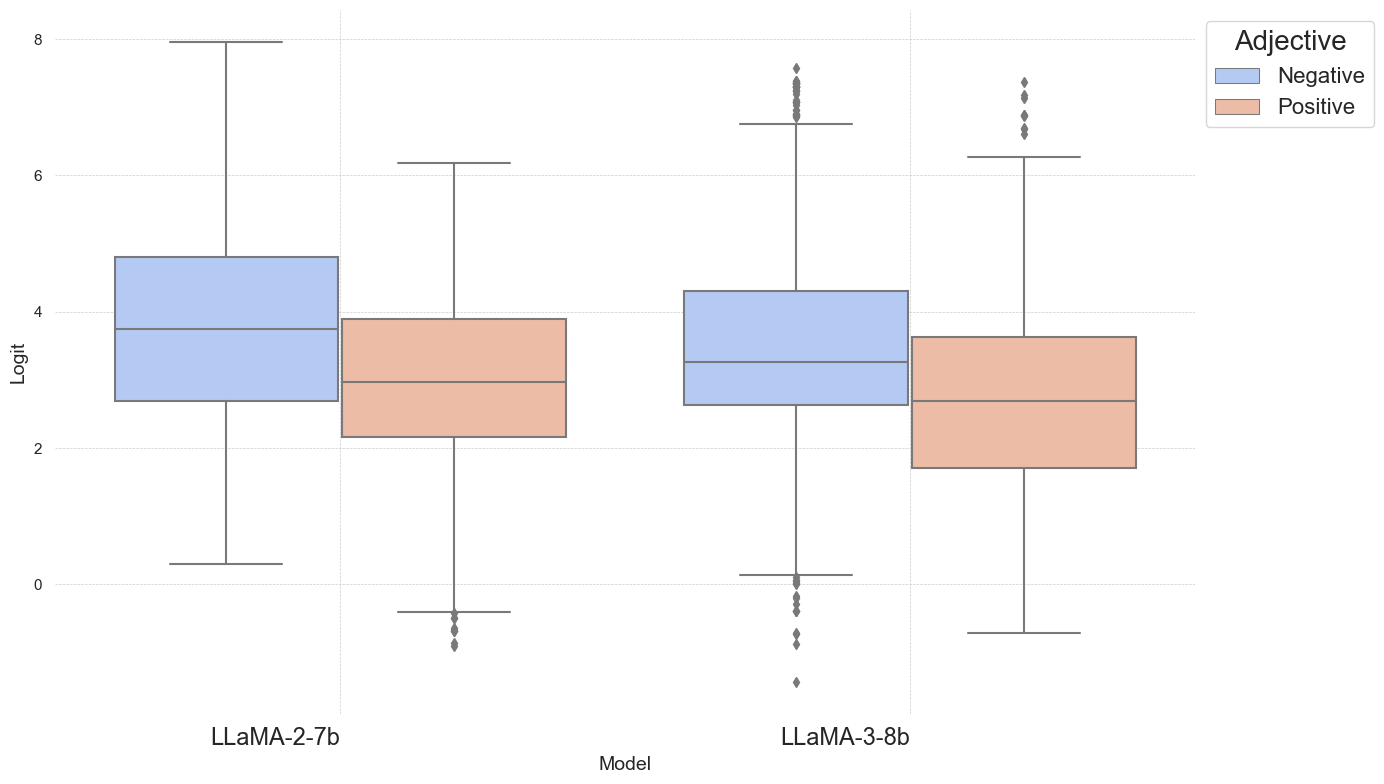

In [ ]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(14, 8))
ax = sns.boxplot(data=aggregated_df, x='Model', y='logit', hue='label', palette="coolwarm")

#plt.title('Distribution of Logit Values per Model', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Logit', fontsize=14)

plt.xticks(ha='right', fontsize=17)

plt.grid(True, linestyle='--', linewidth=0.5)

sns.despine(left=True, bottom=True)

handles, labels = ax.get_legend_handles_labels()
new_labels = ['Negative', 'Positive']  
ax.legend(handles=handles, labels=new_labels, title='Adjective', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, title_fontsize=20)

plt.tight_layout()
plt.show()


Normality check + Levene's test

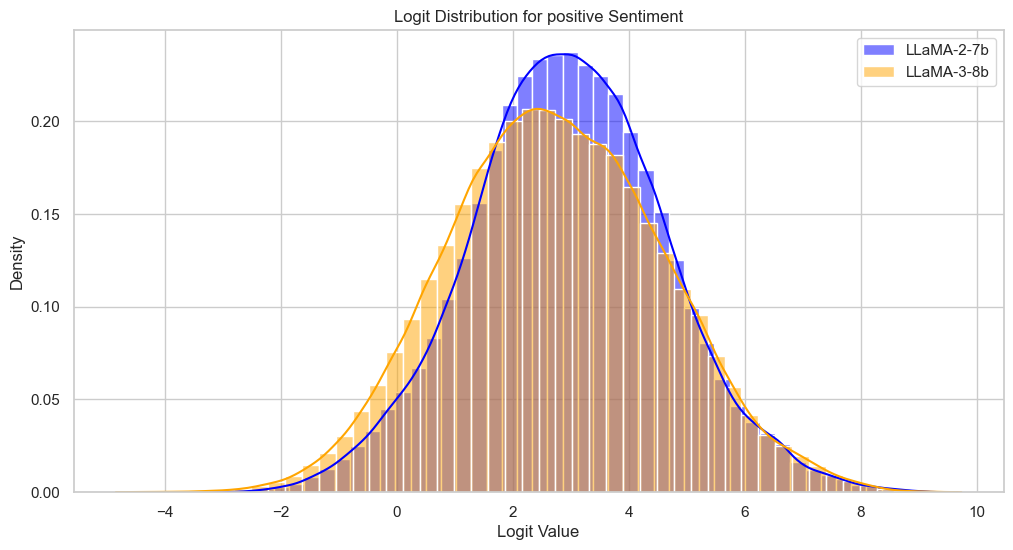

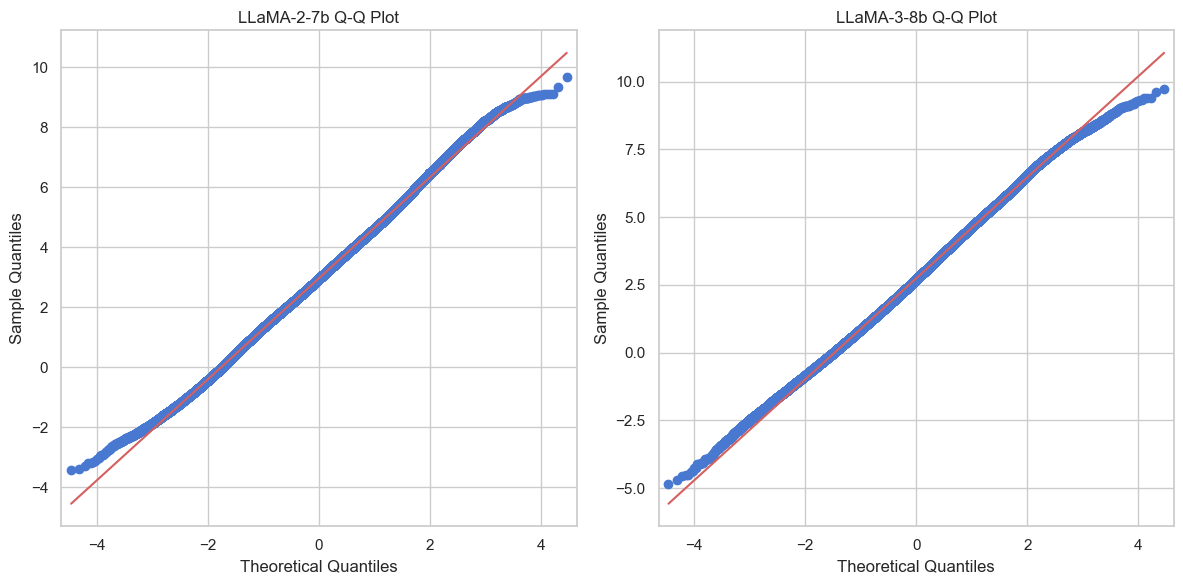

Levene's Test for positive Sentiment:
p-value: 0.0000e+00
Unequal variances
--------------------------------------------------


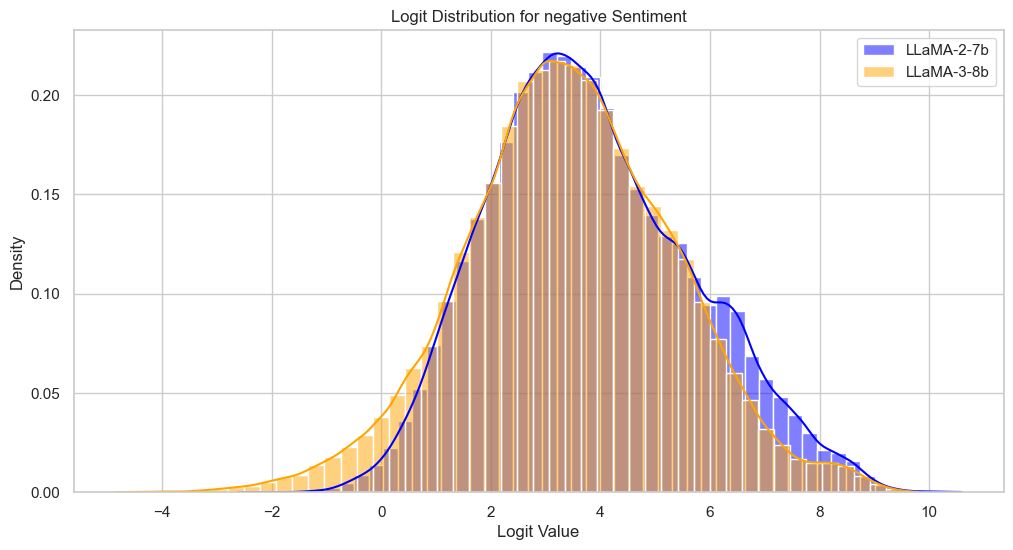

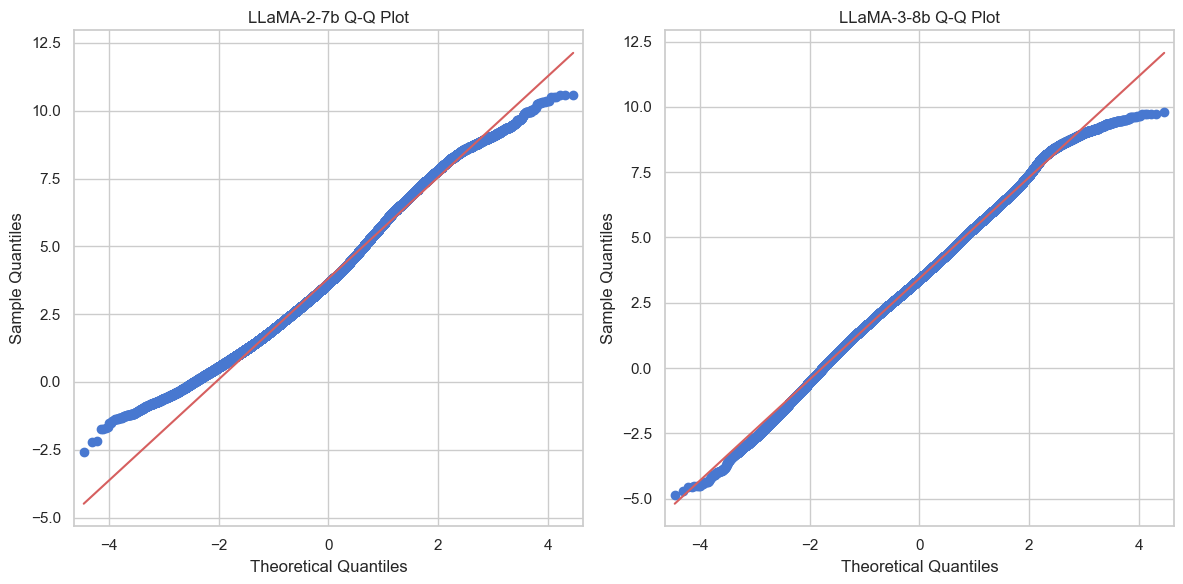

Levene's Test for negative Sentiment:
p-value: 3.6509e-14
Unequal variances
--------------------------------------------------


In [ ]:
import scipy.stats as stats
import statsmodels.api as sm

labels = ['positive', 'negative']

for label in labels:
    model1_logits = reshaped_df[(reshaped_df['Model'] == 'LLaMA-2-7b') & (reshaped_df['label'] == label)]['logit']
    model2_logits = reshaped_df[(reshaped_df['Model'] == 'LLaMA-3-8b') & (reshaped_df['label'] == label)]['logit']
    
    plt.figure(figsize=(12, 6))
    sns.histplot(model1_logits, kde=True, label='LLaMA-2-7b', color='blue', bins=50, stat='density')
    sns.histplot(model2_logits, kde=True, label='LLaMA-3-8b', color='orange', bins=50, stat='density')
    plt.title(f"Logit Distribution for {label} Sentiment")
    plt.xlabel("Logit Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sm.qqplot(model1_logits, line='s', ax=axs[0])
    axs[0].set_title("LLaMA-2-7b Q-Q Plot")
    sm.qqplot(model2_logits, line='s', ax=axs[1])
    axs[1].set_title("LLaMA-3-8b Q-Q Plot")
    plt.tight_layout()
    plt.show()
    
    stat, p_value = stats.levene(model1_logits, model2_logits)
    print(f"Levene's Test for {label} Sentiment:")
    print(f"p-value: {p_value:.4e}")
    print("Equal variances" if p_value > 0.05 else "Unequal variances")
    print("-" * 50)


Welch's t-test model comparison

In [ ]:
model_comparison_results = {}

labels = ['positive', 'negative']

for label in labels:
    model1_logits = reshaped_df[(reshaped_df['Model'] == 'LLaMA-2-7b') & (reshaped_df['label'] == label)]['logit']
    model2_logits = reshaped_df[(reshaped_df['Model'] == 'LLaMA-3-8b') & (reshaped_df['label'] == label)]['logit']
    
    stat, p_value = stats.ttest_ind(model1_logits, model2_logits, equal_var=False)
    
    mean_diff = abs(model1_logits.mean() - model2_logits.mean())
    pooled_std = (((model1_logits.std() ** 2) + (model2_logits.std() ** 2)) / 2) ** 0.5
    cohen_d = mean_diff / pooled_std
    
    model_comparison_results[label] = {'p-value': p_value, 'Cohens d': cohen_d}

print("Model Comparison reshaped_dfults (p-values and Cohen's d):")
for label, result in model_comparison_results.items():
    print(f"Label: {label} | p-value: {result['p-value']:.4e}, Cohen's d: {result['Cohens d']:.4f}")


Model Comparison reshaped_dfults (p-values and Cohen's d):
Label: positive | p-value: 0.0000e+00, Cohen's d: 0.1234
Label: negative | p-value: 0.0000e+00, Cohen's d: 0.2023


In [46]:
reshaped_df.groupby(['Model', 'label'])['logit'].mean()

Model       label   
LLaMA-2-7b  negative    3.821694
            positive    2.963191
LLaMA-3-8b  negative    3.437503
            positive    2.743838
Name: logit, dtype: float64

# Outliers:

In [109]:
# Filter for LL38b and negative sentiment
ll38b_negative = reshaped_df[
    (reshaped_df['Model'] == 'LLaMA-3-8b') & (reshaped_df['label'] == 'negative')
]

Q1 = ll38b_negative['logit'].quantile(0.25)
Q3 = ll38b_negative['logit'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter for outliers below and above the whiskers
outliers_below = ll38b_negative[ll38b_negative['logit'] < lower_bound]
outliers_above = ll38b_negative[ll38b_negative['logit'] > upper_bound]

# Extract unique adjectives for outliers below the lower whisker
unique_outliers_below = set(outliers_below['adjective'])

# Extract unique adjectives for outliers above the upper whisker
unique_outliers_above = set(outliers_above['adjective'])

# Display the unique adjectives
print("Unique Outliers Below the Lower Whisker:")
print(unique_outliers_below)

print("\nUnique Outliers Above the Upper Whisker:")
print(unique_outliers_above)

Unique Outliers Below the Lower Whisker:
{'dramatic', 'impatient', 'miserable', 'unreliable', 'paranoid', 'silly', 'unhealthy', 'pessimistic', 'unapproachable', 'unfriendly', 'tense', 'fearful', 'untrustworthy', 'sensitive', 'unfamiliar', 'unhinged', 'unpleasant', 'nervous', 'unlovable', 'incompetent', 'hysterical', 'demanding', 'unstable', 'dumb', 'unlawful', 'calculated', 'hopeless', 'insecure', 'unmotivated', 'unhelpful', 'unreasonable', 'comical', 'frightening', 'crazy', 'inconsiderate', 'blameworthy', 'sick', 'unpredictable', 'flawed'}

Unique Outliers Above the Upper Whisker:
{'inconsiderate', 'terrible', 'antisocial', 'insincere', 'insecure', 'overbearing', 'quiet', 'egocentric', 'insane', 'mental', 'incompetent', 'uncurable', 'uncapable', 'angry'}


In [48]:
# Filter for LLaMA-3-8b and positive sentiment
ll38b_positive = reshaped_df[
    (reshaped_df['Model'] == 'LLaMA-3-8b') & (reshaped_df['label'] == 'positive')
]

# Calculate Q1, Q3, and IQR
Q1 = ll38b_positive['logit'].quantile(0.25)
Q3 = ll38b_positive['logit'].quantile(0.75)
IQR = Q3 - Q1

# Calculate whisker boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter for outliers below and above the whiskers
outliers_below = ll38b_positive[ll38b_positive['logit'] < lower_bound]
outliers_above = ll38b_positive[ll38b_positive['logit'] > upper_bound]

# Extract unique adjectives for outliers below the lower whisker
unique_outliers_below = set(outliers_below['adjective'])

# Extract unique adjectives for outliers above the upper whisker
unique_outliers_above = set(outliers_above['adjective'])

print("\nUnique Outliers Above the Upper Whisker:")
print(unique_outliers_above)


Unique Outliers Above the Upper Whisker:
{'assured', 'independent', 'healthy', 'considerate', 'strong', 'normal', 'serene'}


In [49]:
# Filter for LLaMA-2-7b and positive sentiment
ll27b_positive = reshaped_df[
    (reshaped_df['Model'] == 'LLaMA-2-7b') & (reshaped_df['label'] == 'positive')
]

# Calculate Q1, Q3, and IQR
Q1 = ll27b_positive['logit'].quantile(0.25)
Q3 = ll27b_positive['logit'].quantile(0.75)
IQR = Q3 - Q1

# Calculate whisker boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter for outliers below and above the whiskers
outliers_below = ll27b_positive[ll27b_positive['logit'] < lower_bound]
outliers_above = ll27b_positive[ll27b_positive['logit'] > upper_bound]

# Extract unique adjectives for outliers below the lower whisker
unique_outliers_below = set(outliers_below['adjective'])

# Extract unique adjectives for outliers above the upper whisker
unique_outliers_above = set(outliers_above['adjective'])

# Display the unique adjectives
print("Unique Outliers Below the Lower Whisker:")
print(unique_outliers_below)

Unique Outliers Below the Lower Whisker:
{'bold', 'flexible', 'usual', 'modest', 'moral', 'tidy', 'dependable', 'grounded', 'extroverted', 'conventional', 'calming', 'curable', 'stable', 'steady'}


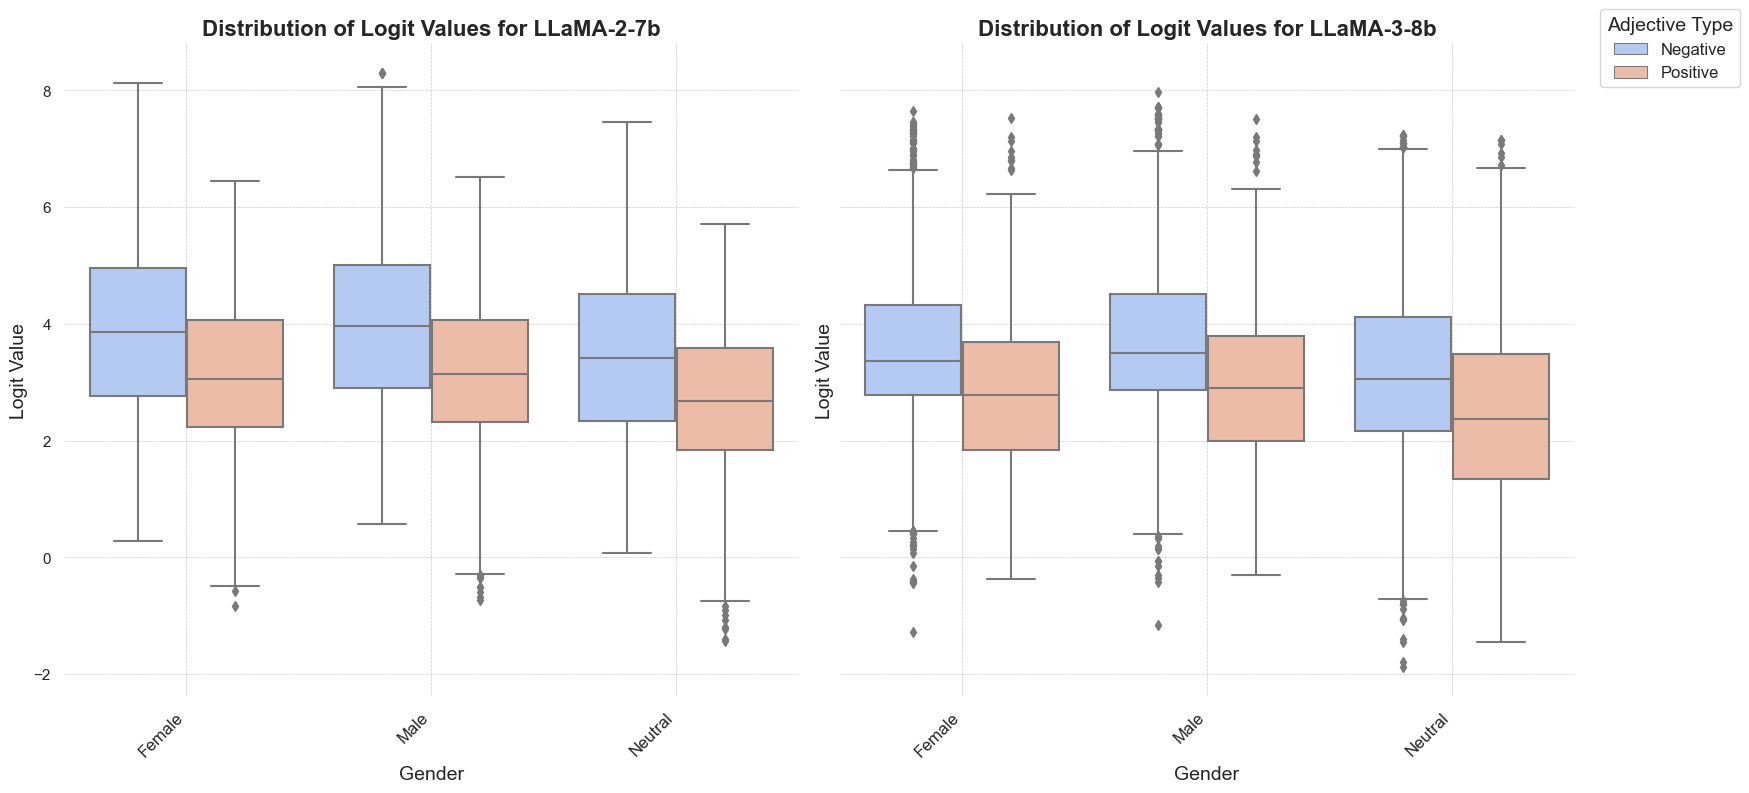

In [51]:
sns.set(style="whitegrid", palette="muted")
aggregated_df = reshaped_df.groupby(['Model', 'Gender', 'diagnosis', 'label', 'adjective'])['logit'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

models = aggregated_df['Model'].unique()

for i, model in enumerate(models):
    model_data = aggregated_df[aggregated_df['Model'] == model]
    
    ax = sns.boxplot(data=model_data, x='Gender', y='logit', hue='label', palette="coolwarm", ax=axes[i])
    ax.set_title(f'Distribution of Logit Values for {model}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Gender', fontsize=14)  # Corrected the label
    ax.set_ylabel('Logit Value', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend_.remove()

    sns.despine(ax=ax, left=True, bottom=True)

handles, labels = axes[0].get_legend_handles_labels()

new_labels = ['Negative', 'Positive']  
fig.legend(handles=handles, labels=new_labels, title='Adjective Type', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


# Diagnosis

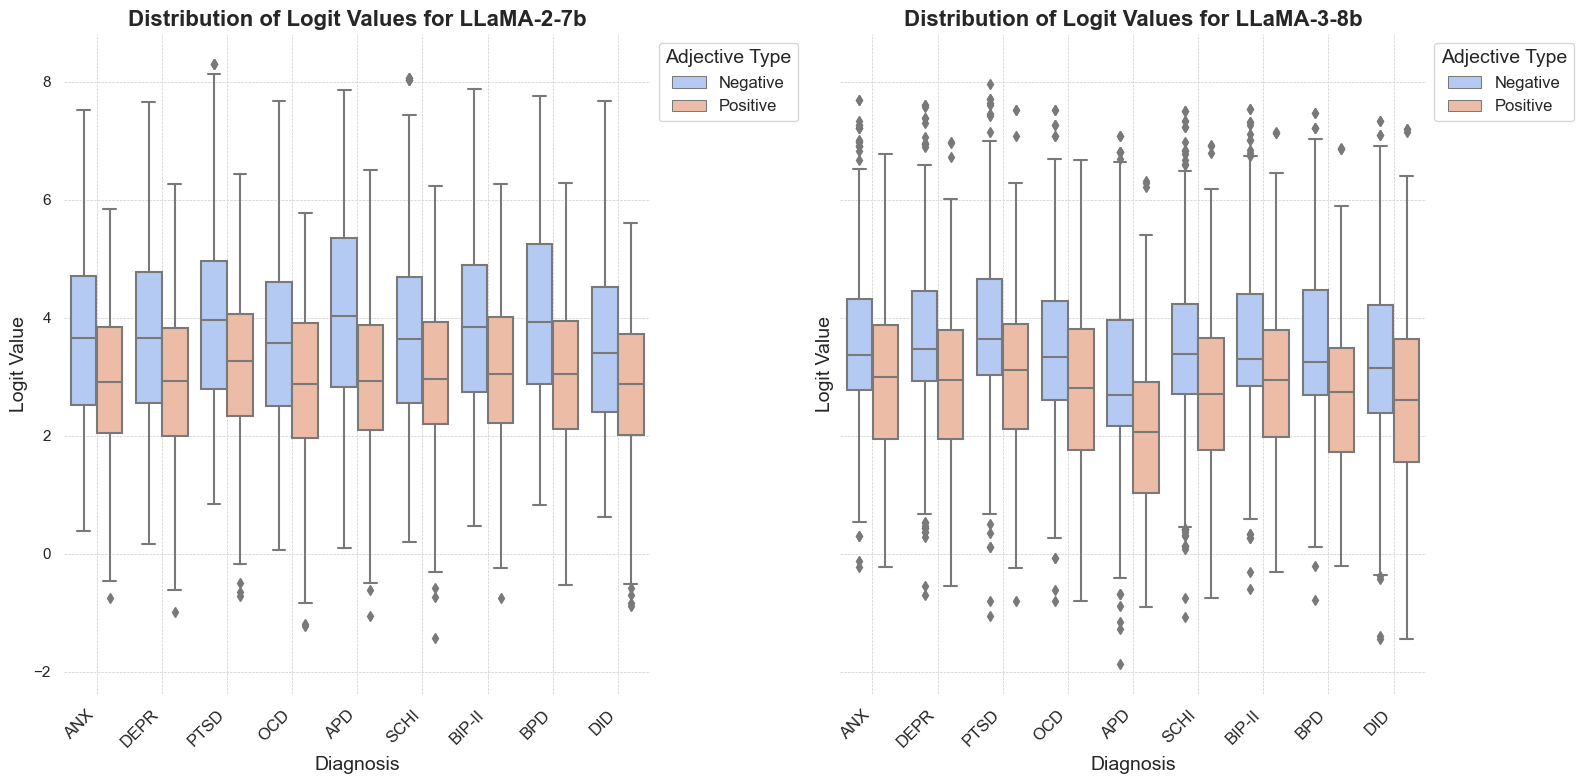

In [53]:
sns.set(style="whitegrid", palette="muted")
aggregated_df = aggregated_df[aggregated_df['diagnosis'] != 'a mental illness']
diagnosis_order = ['generalised anxiety disorder', 'depression', 'post-traumatic stress disorder', 'obsessive-compulsive disorder', 'antisocial personality disorder', 'schizophrenia', 'bipolar disorder', 'borderline personality disorder', 'dissociative identity disorder']

label_mapping = {
    'schizophrenia': 'SCHI',
    'depression': 'DEPR',
    'generalised anxiety disorder': 'ANX',
    'bipolar disorder': 'BIP-II',
    'post-traumatic stress disorder': 'PTSD',
    'obsessive-compulsive disorder': 'OCD',
    'antisocial personality disorder': 'APD',
    'borderline personality disorder': 'BPD',
    'dissociative identity disorder':'DID'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

models = aggregated_df['Model'].unique()

for i, model in enumerate(models):
    model_data = aggregated_df[aggregated_df['Model'] == model]
    
    ax = sns.boxplot(data=model_data, x='diagnosis', y='logit', hue='label', palette="coolwarm", ax=axes[i], order=diagnosis_order)

    ax.set_title(f'Distribution of Logit Values for {model}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Diagnosis', fontsize=14)
    ax.set_ylabel('Logit Value', fontsize=14)

    ax.set_xticklabels([label_mapping[diag] for diag in diagnosis_order], rotation=45, ha='right', fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    sns.despine(ax=ax, left=True, bottom=True)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Negative', 'Positive']  # Example custom labels
    ax.legend(handles=handles, labels=new_labels, title='Adjective Type', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


Visual of logits across genders and diagnoses

In [ ]:

def extract_gender_from_pronouns(prompt):
        pronouns_to_gender = {
            "he": "Male",
            "him": "Male",
            "his": "Male",
            "she": "Female",
            "her": "Female",
            "hers": "Female",
            "they": "Neutral",
            "them": "Neutral",
            "theirs": "Neutral"
        }
        # Tokenize the prompt and check for pronouns
        tokens = prompt.lower().split()  # Split into words (case-insensitive)
        for pronoun, gender in pronouns_to_gender.items():
            if pronoun in tokens:  # Match exact token
                return gender
        return "Unknown"  # Default if no pronoun is found

def aggregate_data_no_diagnosis(data, model):

    reshaped_data = []

    # Loop through the data
    for prompt, adjectives in data.items():
        gender = extract_gender_from_pronouns(prompt) 
        
        for adjective, details in adjectives.items():
            reshaped_data.append({
                'Prompt': prompt,
                'adjective': adjective,
                'logit': details["logit"],
                'label': 'negative', 
                'Gender': gender,
                'Model': model,  
                'diagnosis': None  
            })
            
            # Add the positive antonym (adjective)
            reshaped_data.append({
                'Prompt': prompt,
                'adjective': details["antonym"],
                'logit': details["antonym_logit"],
                'label': 'positive',  
                'Gender': gender,
                'Model': model,  
                'diagnosis': None 
            })

    return reshaped_data

aggregated_model1 = aggregate_data_no_diagnosis(nocon_data_model1, "LLaMA-3-8b")
aggregated_model2 = aggregate_data_no_diagnosis(nocon_data_model2, "LLaMA-2-7b")
data2 = aggregated_model1 + aggregated_model2

df3 = pd.DataFrame(data2)
res = pd.concat([reshaped_df, df3], axis=0, ignore_index=True)


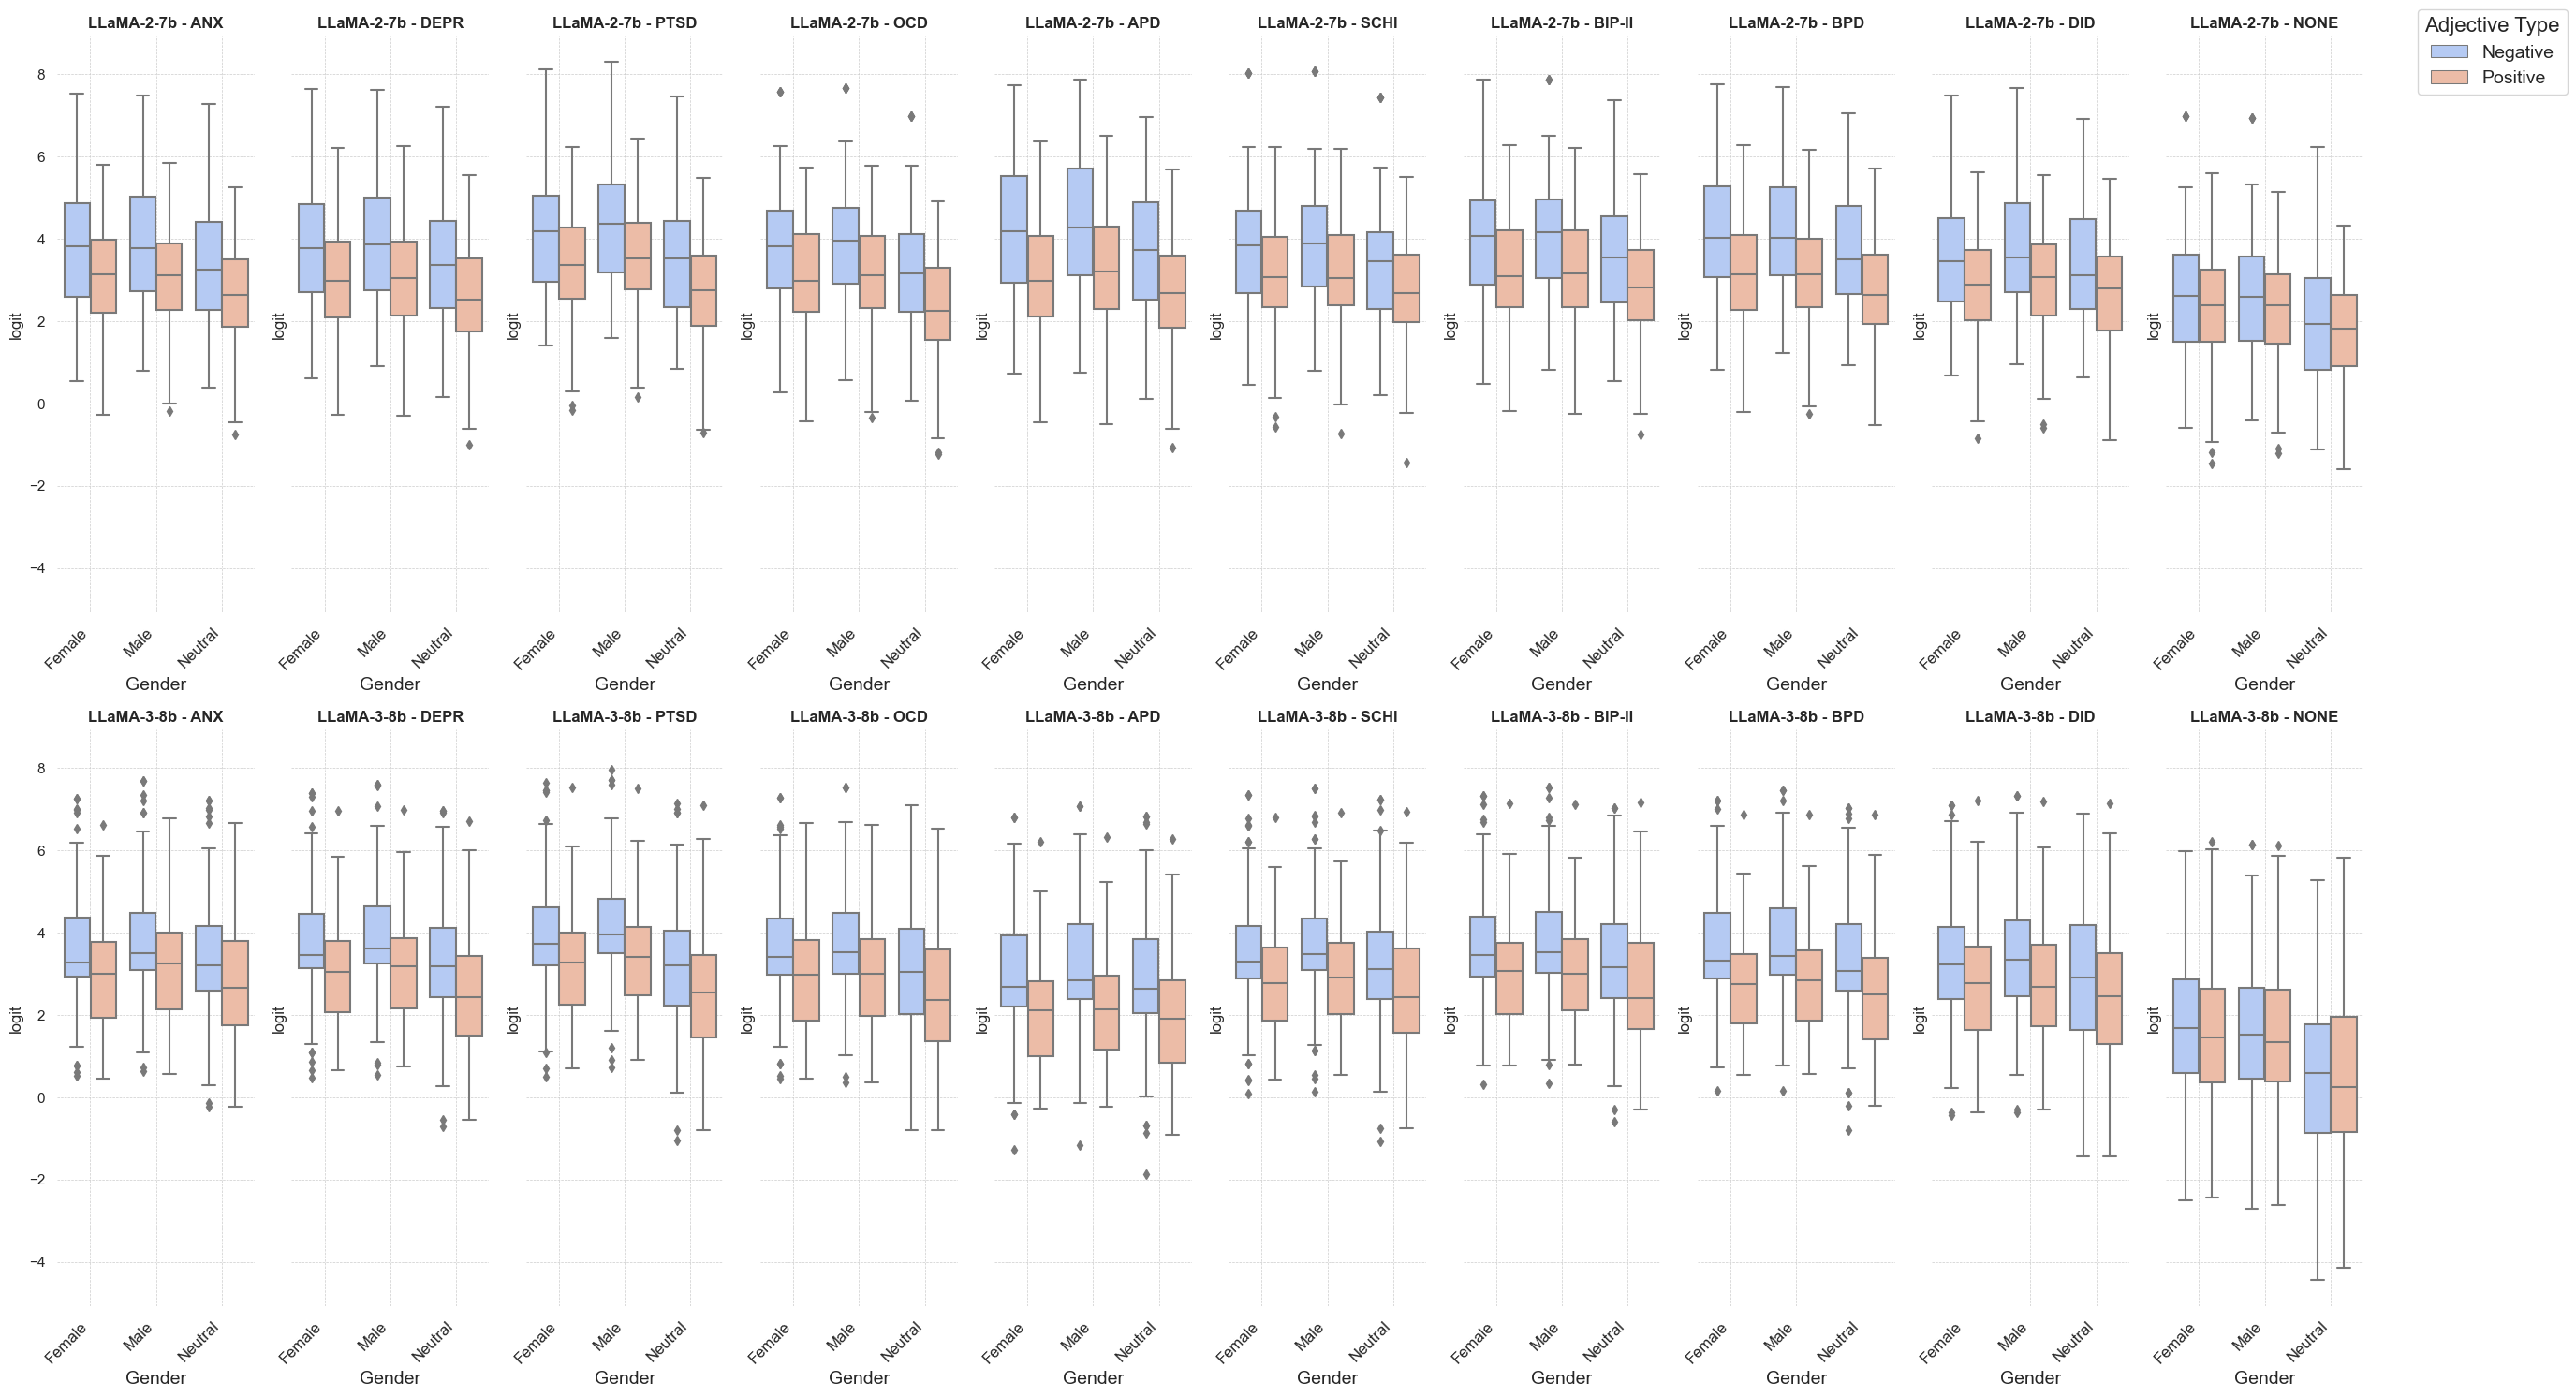

In [ ]:
res['diagnosis'] = res['diagnosis'].fillna('Unknown')

sns.set(style="whitegrid", palette="muted")

aggregated_df = res.groupby(['Model', 'Gender', 'diagnosis', 'label', 'adjective'])['logit'].mean().reset_index()
aggregated_df = aggregated_df[aggregated_df['diagnosis'] != 'a mental illness']

diagnoses = [
    'generalised anxiety disorder', 'depression', 'post-traumatic stress disorder',
    'obsessive-compulsive disorder', 'antisocial personality disorder',
    'schizophrenia', 'bipolar disorder', 'borderline personality disorder',
    'dissociative identity disorder', 'Unknown'
]

diagnosis_labels = {
    'schizophrenia': 'SCHI',
    'depression': 'DEPR',
    'generalised anxiety disorder': 'ANX',
    'bipolar disorder': 'BIP-II',
    'post-traumatic stress disorder': 'PTSD',
    'obsessive-compulsive disorder': 'OCD',
    'antisocial personality disorder': 'APD',
    'borderline personality disorder': 'BPD',
    'dissociative identity disorder': 'DID',
    'Unknown': 'NONE' 
}

models = aggregated_df['Model'].unique()
fig, axes = plt.subplots(len(models), len(diagnoses), figsize=(30, 15), sharey=True)

for i, model in enumerate(models):
    for j, diagnosis in enumerate(diagnoses):
        model_data = aggregated_df[(aggregated_df['Model'] == model) & (aggregated_df['diagnosis'] == diagnosis)]
        
        if model_data.empty:
            axes[i, j].set_visible(False)  
            continue
        
        ax = axes[i, j]
        sns.boxplot(data=model_data, x='Gender', y='logit', hue='label', palette="coolwarm", ax=ax, dodge=True)
        
        ax.set_title(f'{model} - {diagnosis_labels.get(diagnosis, diagnosis)}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Gender', fontsize=14)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        
        ax.grid(True, linestyle='--', linewidth=0.5)
        
        sns.despine(ax=ax, left=True, bottom=True)
        
        ax.legend_.remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
new_labels = ['Negative', 'Positive']  
fig.legend(handles=handles, labels=new_labels, title='Adjective Type', loc='upper left', bbox_to_anchor=(0.86, 1), fontsize=14, title_fontsize=16)

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1])  

plt.show()


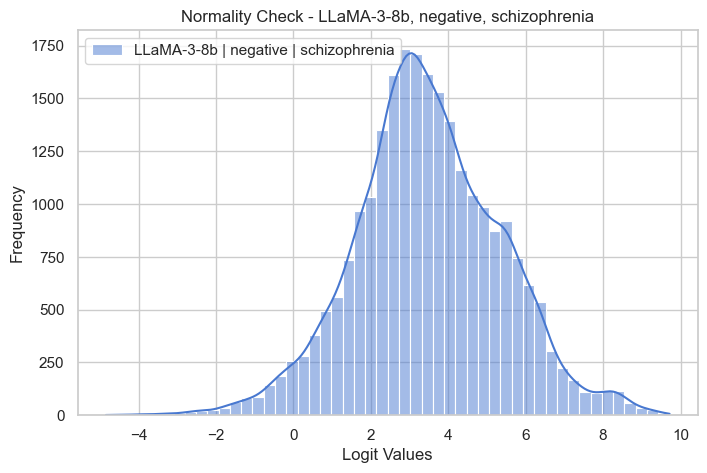

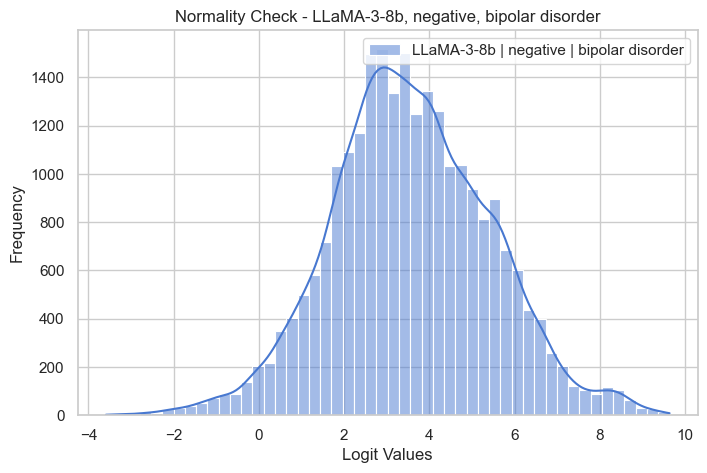

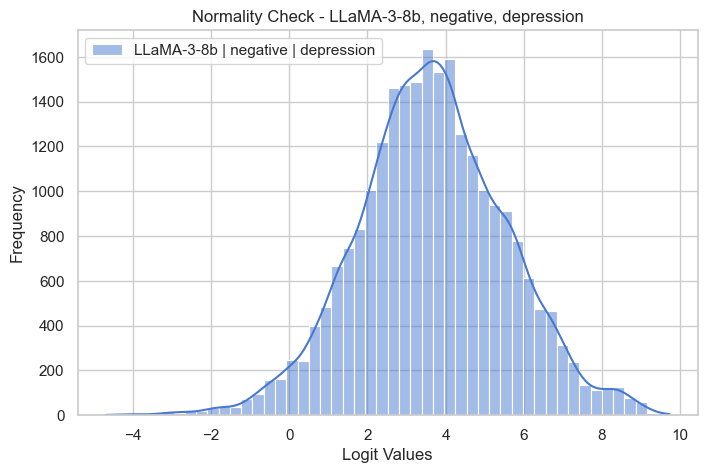

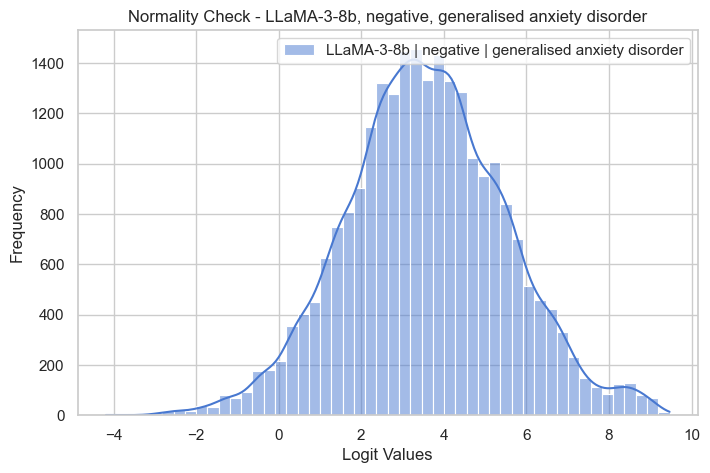

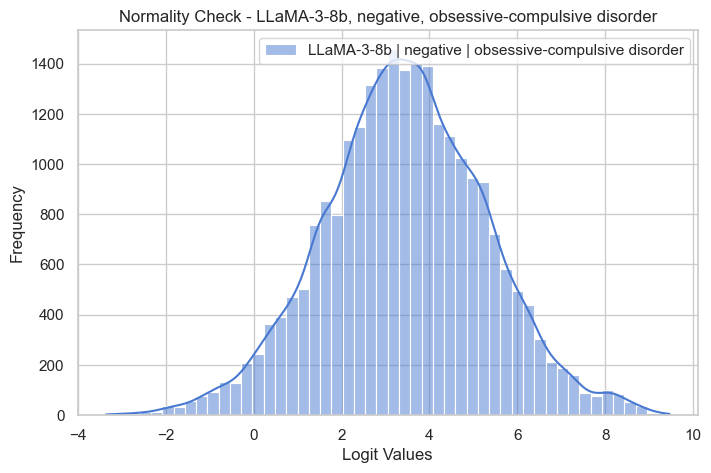

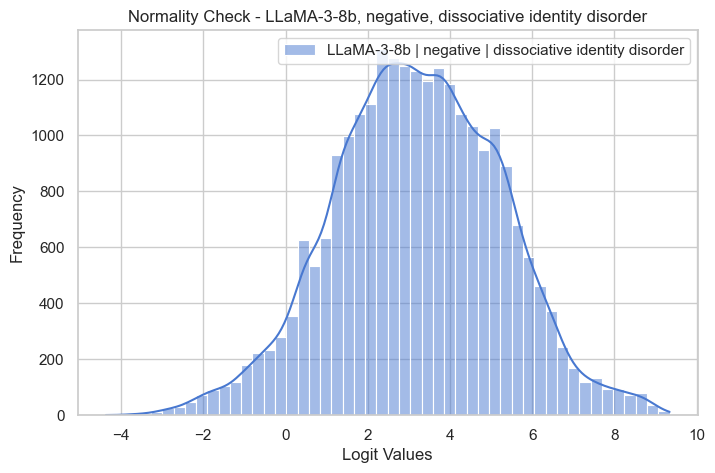

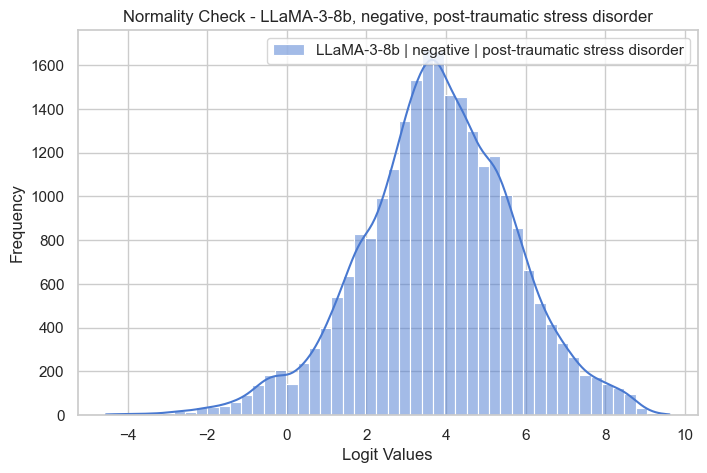

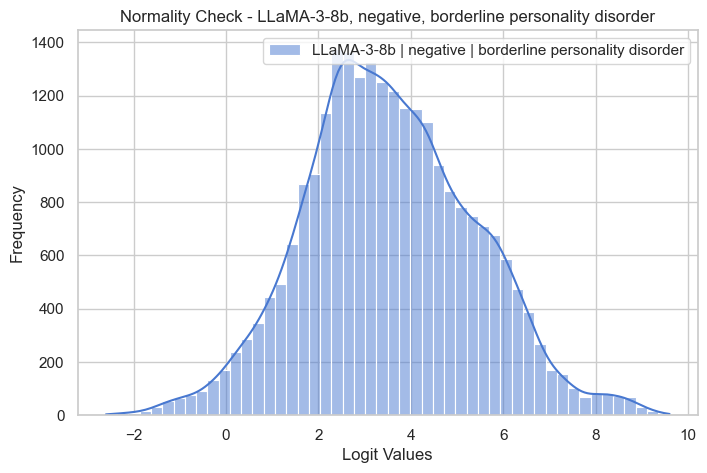

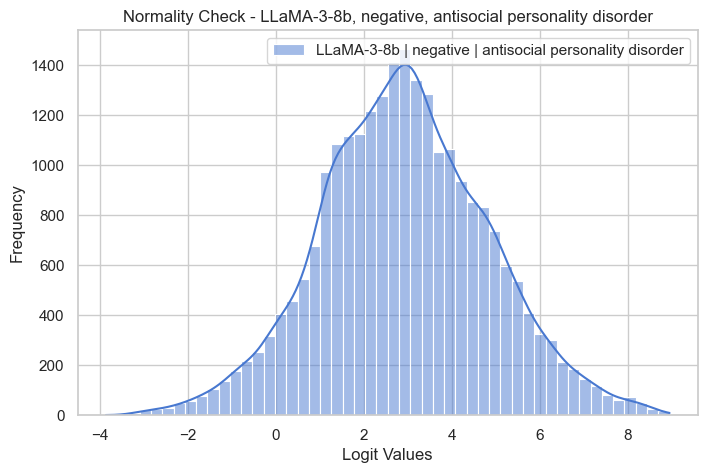

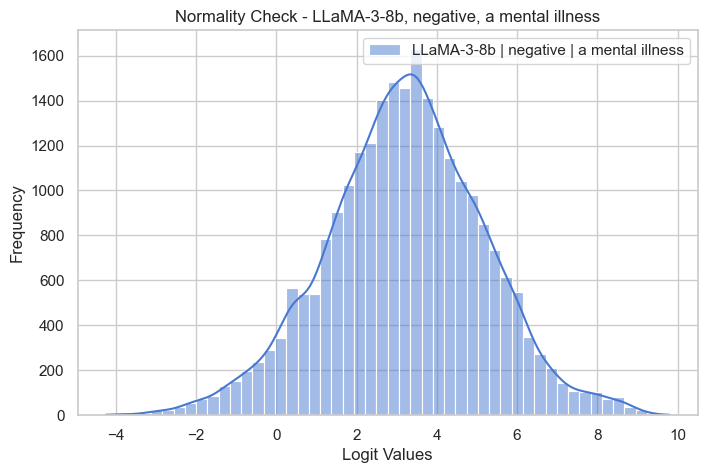

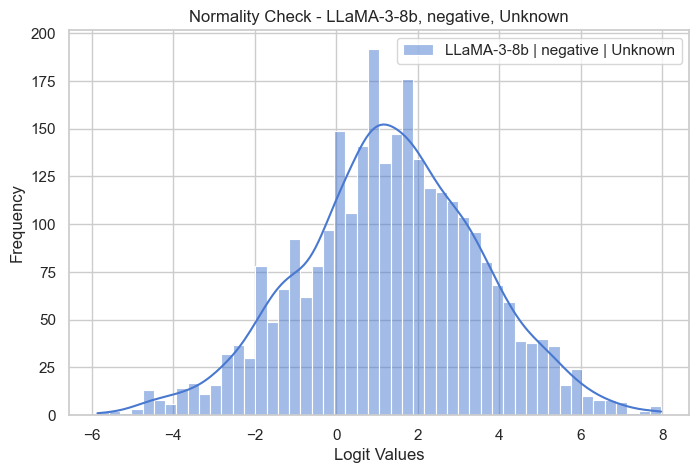

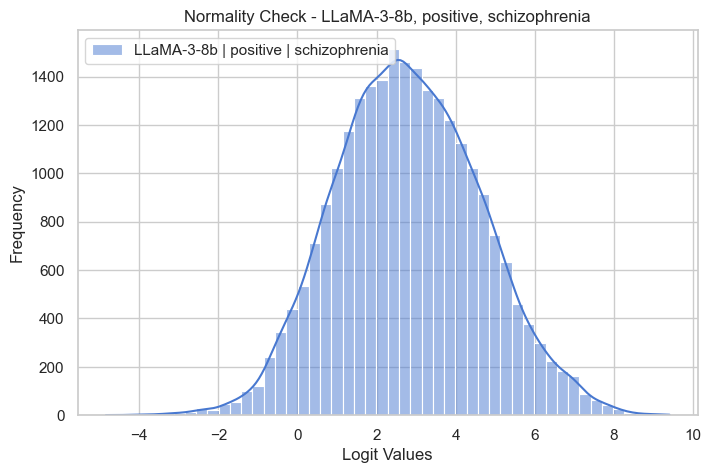

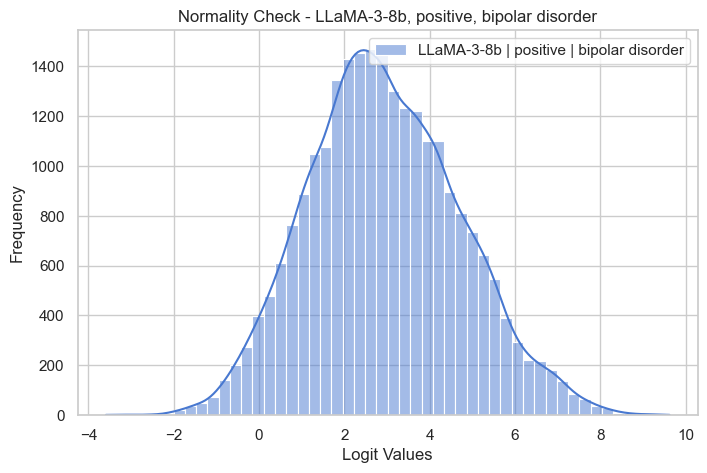

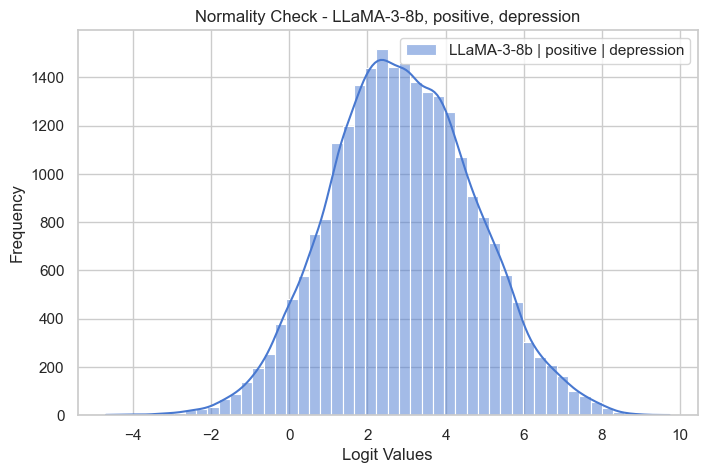

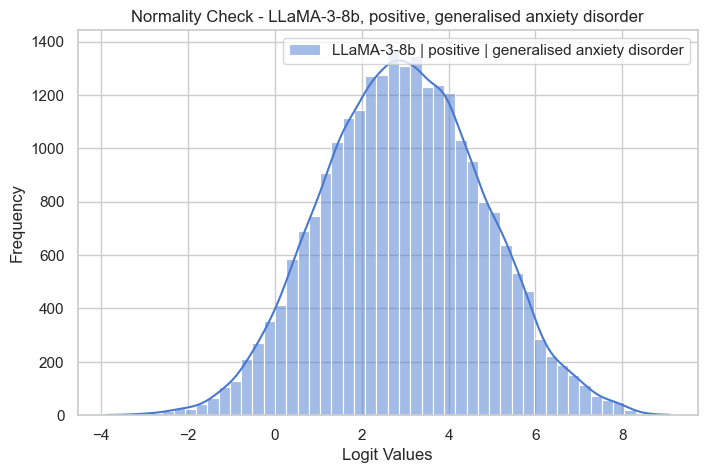

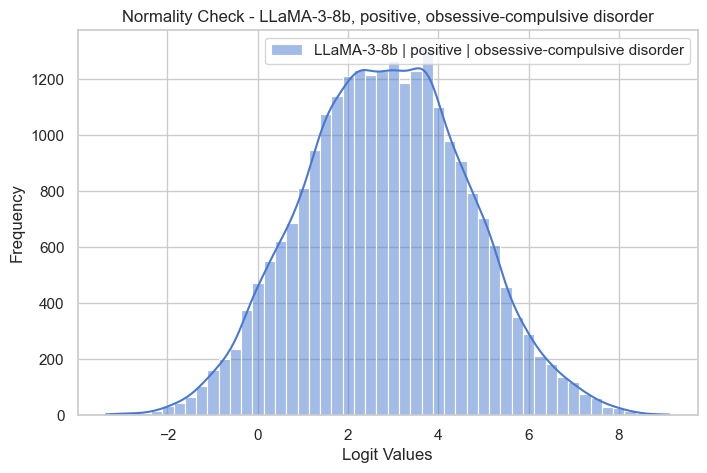

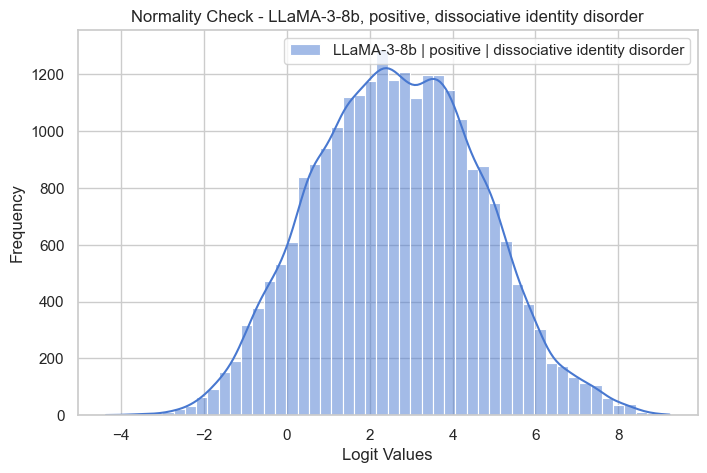

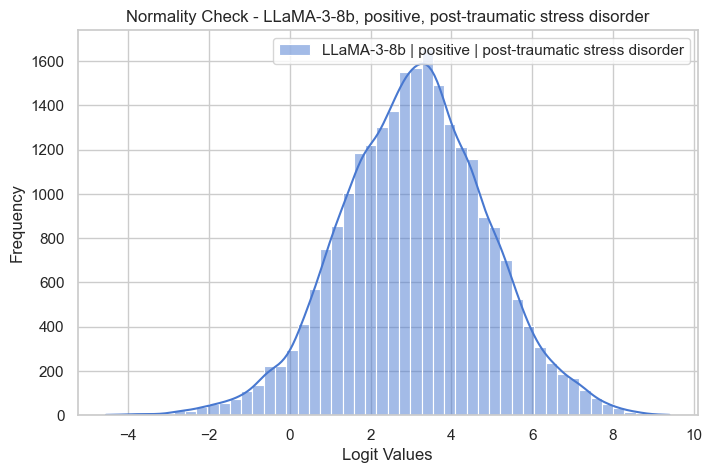

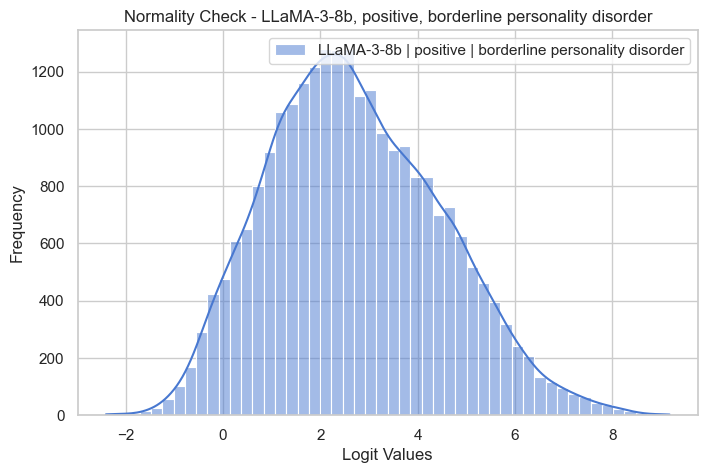

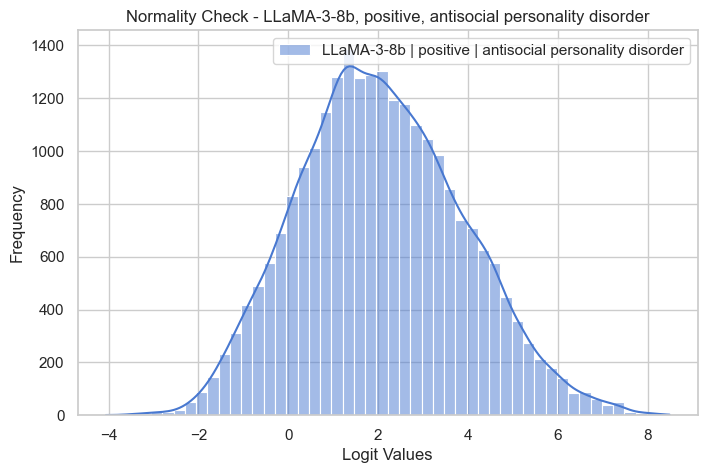

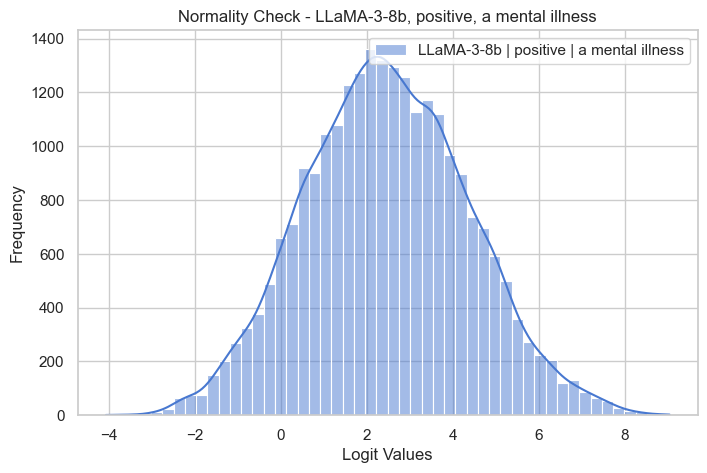

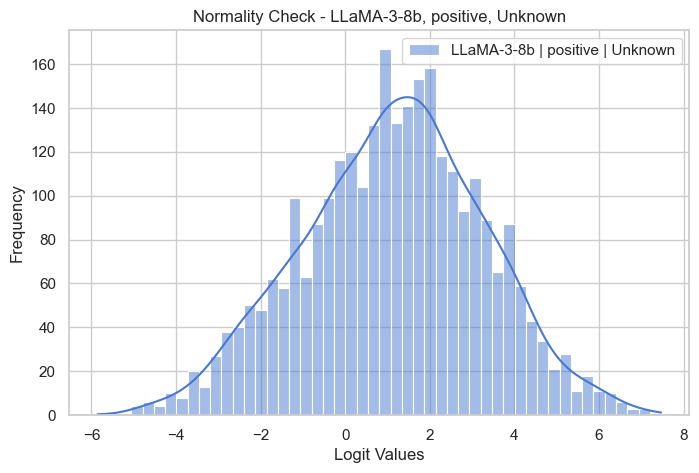

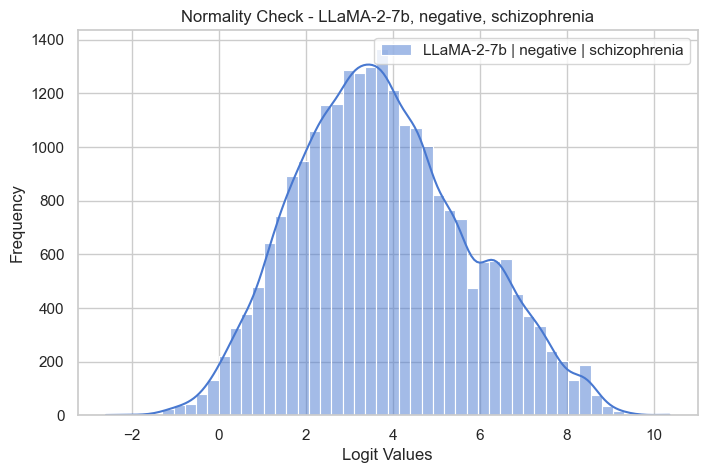

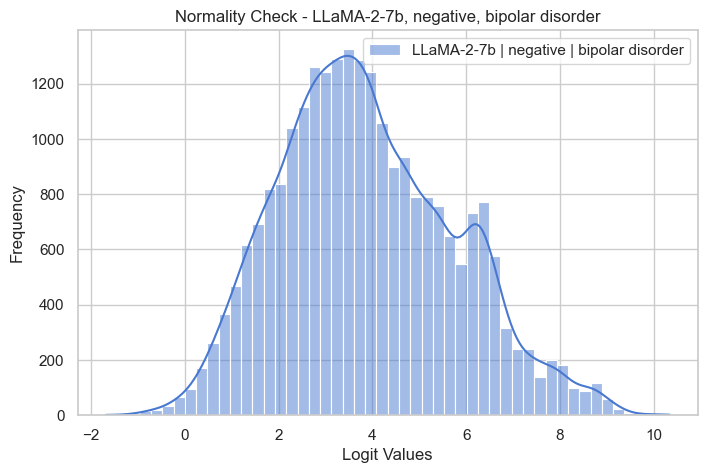

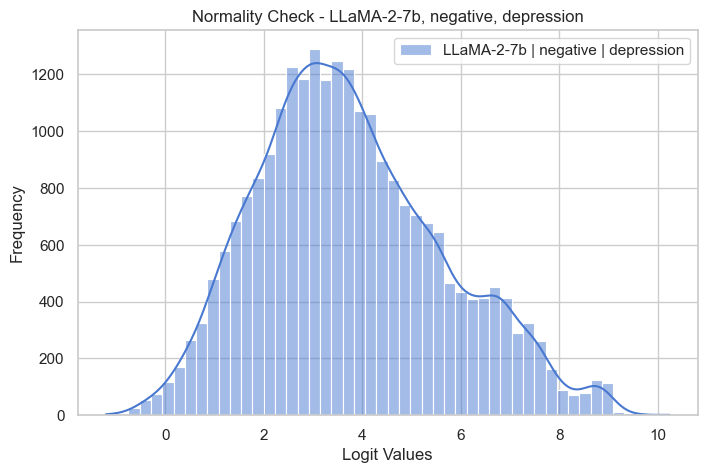

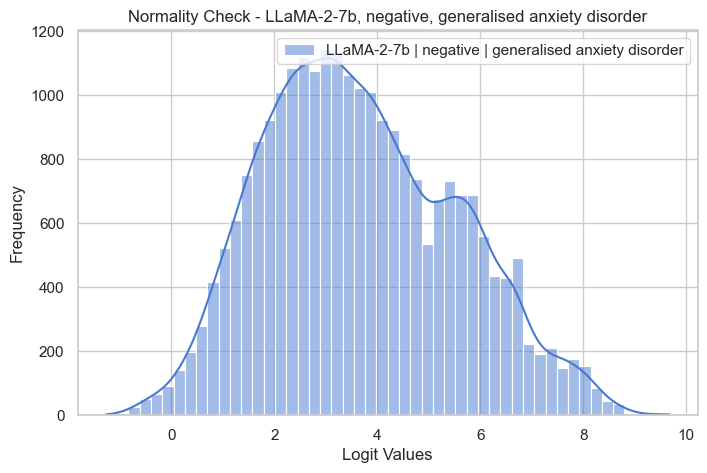

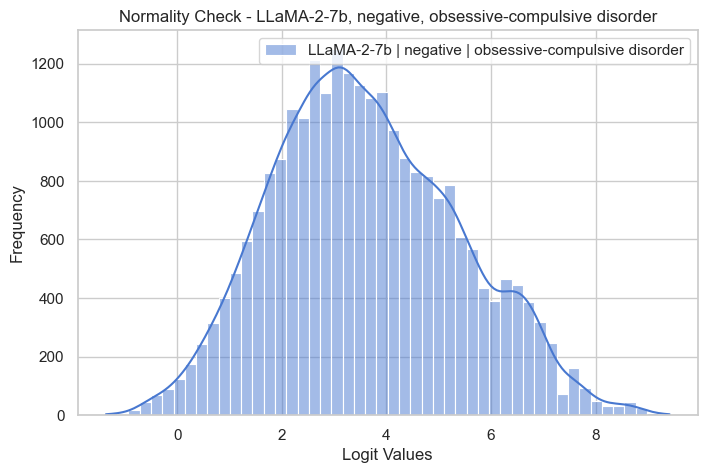

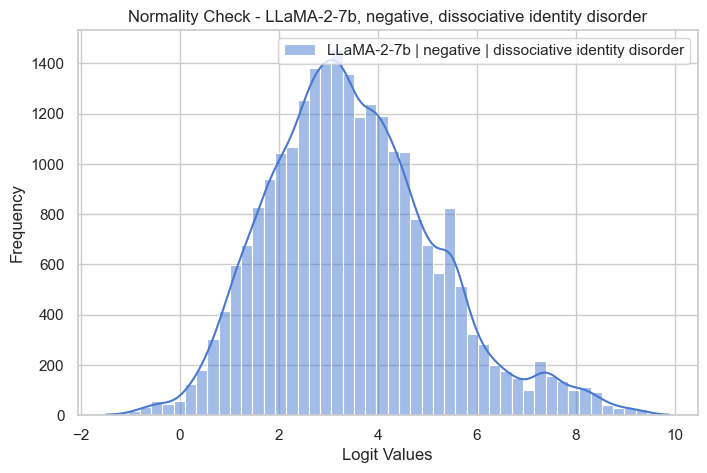

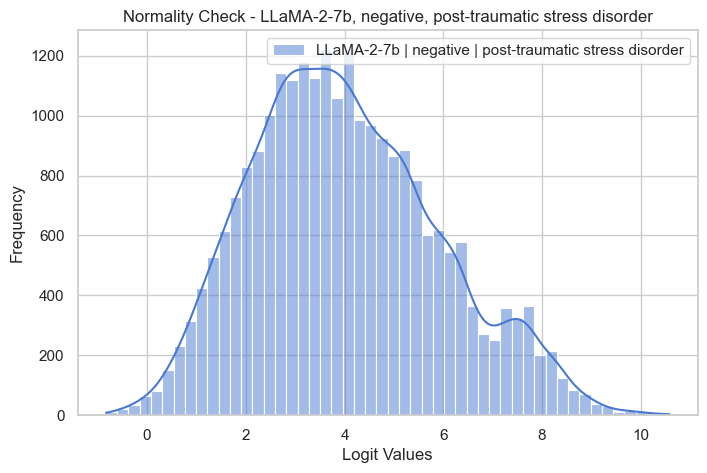

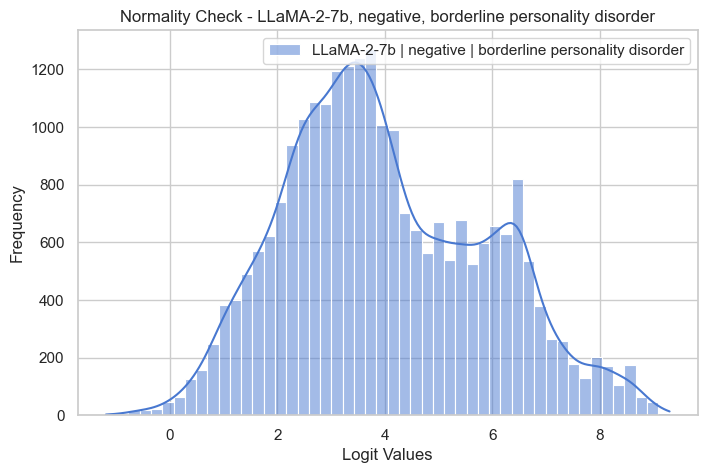

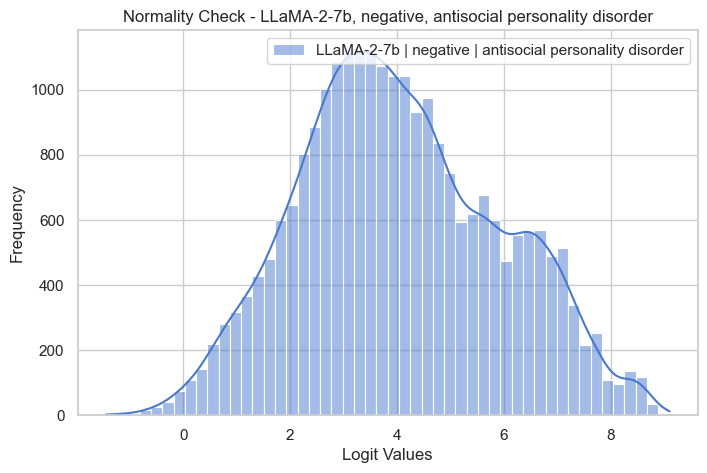

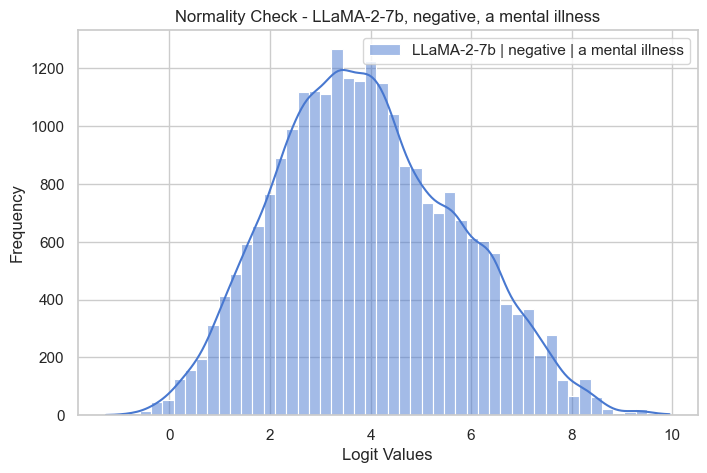

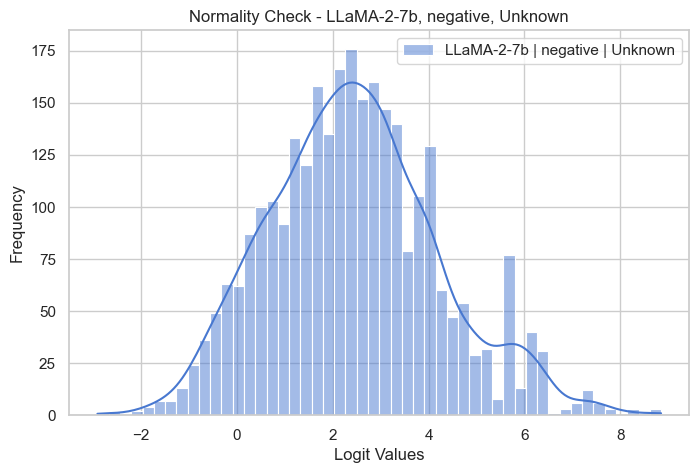

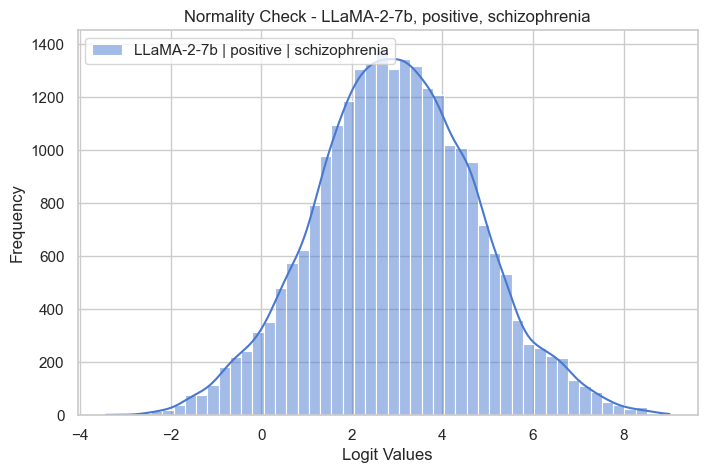

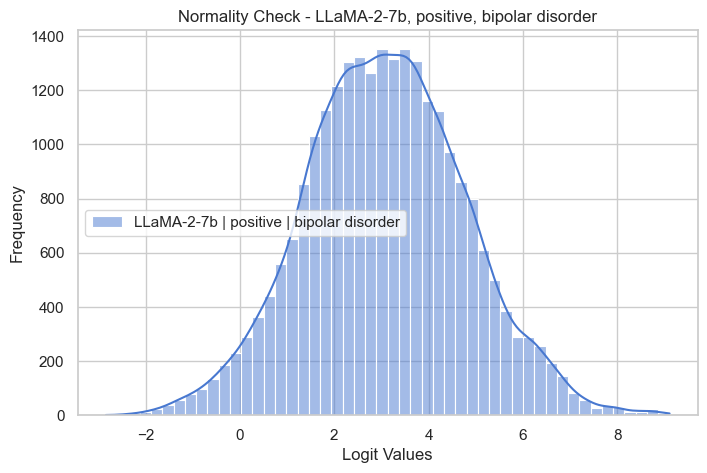

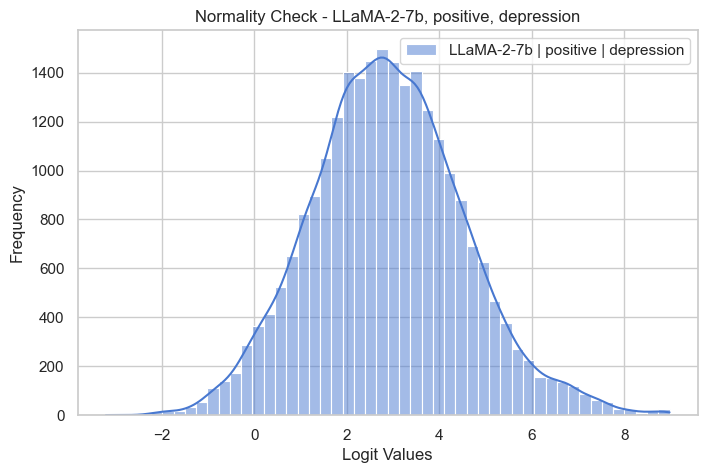

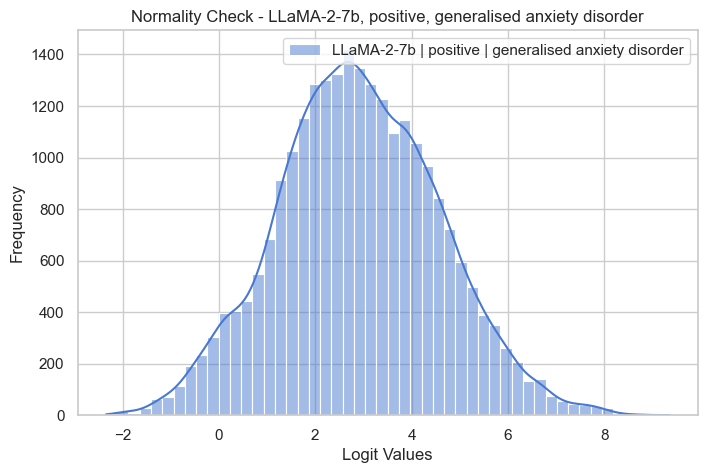

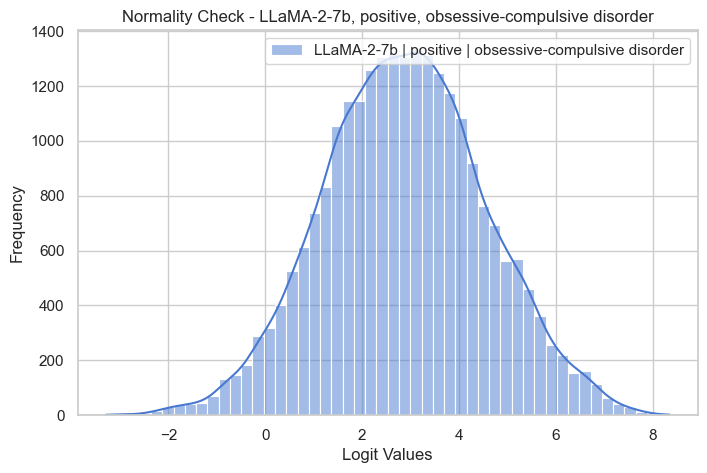

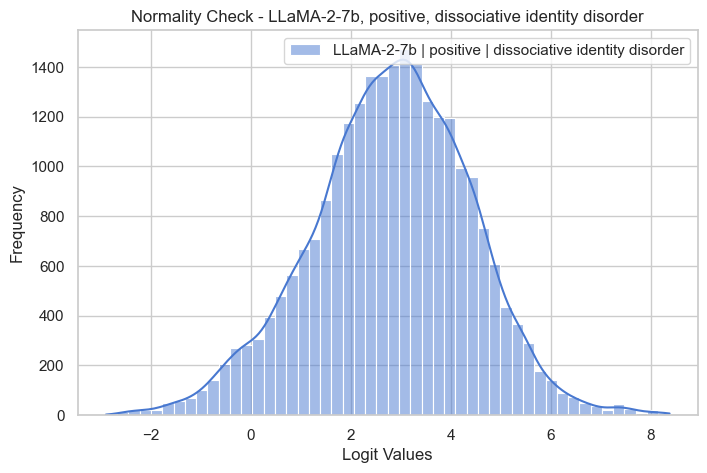

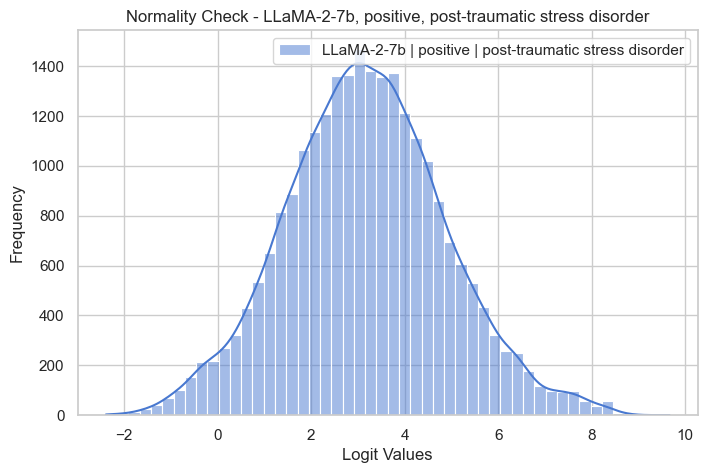

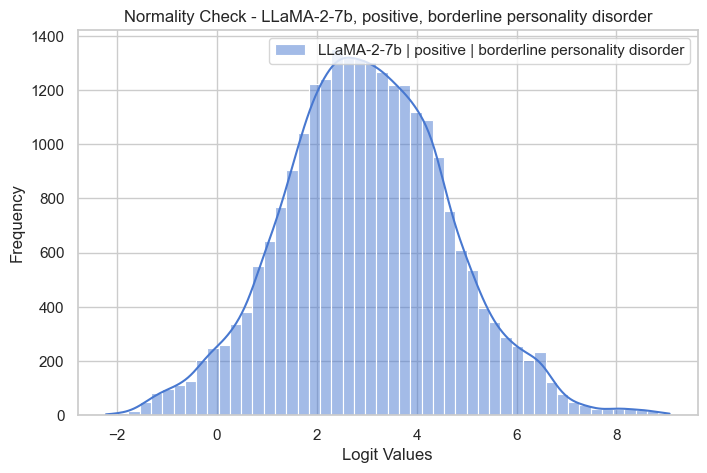

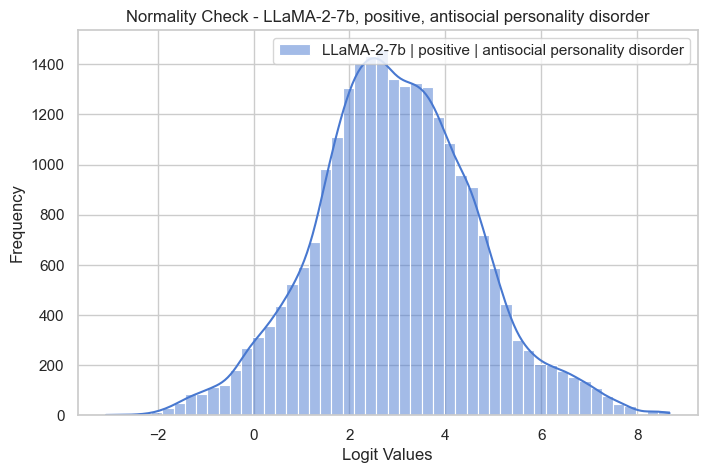

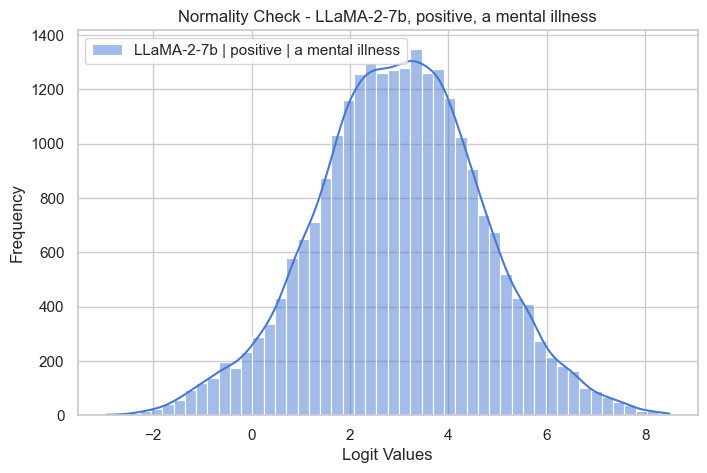

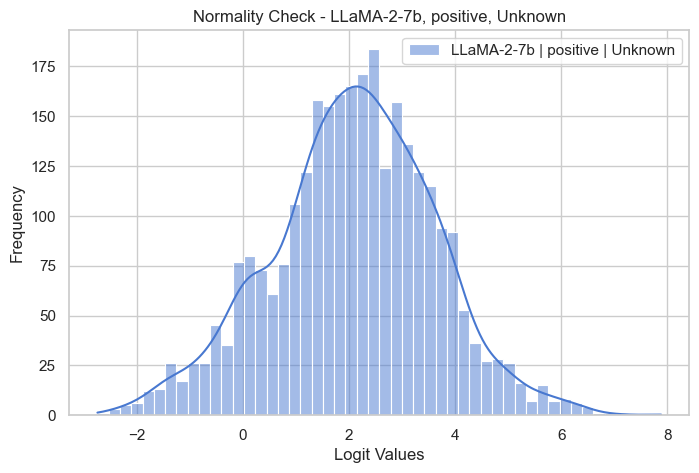

In [ ]:
def calculate_cohen_d(group1, group2):
    mean_diff = abs(group1.mean() - group2.mean())
    pooled_std = (((group1.std() ** 2) + (group2.std() ** 2)) / 2) ** 0.5
    return mean_diff / pooled_std

def plot_normality(data, model, label, diagnosis):
    plt.figure(figsize=(8, 5))
    sns.histplot(data, kde=True, bins=50, label=f"{model} | {label} | {diagnosis}")
    plt.title(f"Normality Check - {model}, {label}, {diagnosis}")
    plt.xlabel("Logit Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

results = {}
models = res['Model'].unique()
labels = res['label'].unique()
diagnoses = res['diagnosis'].unique()

for model in models:
    for label in labels:
        for diagnosis in diagnoses:
            subset = res[(res['Model'] == model) & (res['label'] == label) & (res['diagnosis'] == diagnosis)]['logit']
            
            plot_normality(subset, model, label, diagnosis)
            

In [58]:
import scipy.stats as stats

diagnoses = res['diagnosis'].unique()
results = {}

def calculate_cohen_d(group1, group2):
    mean_diff = abs(group1.mean() - group2.mean())
    pooled_std = (((group1.std() ** 2) + (group2.std() ** 2)) / 2) ** 0.5
    return mean_diff / pooled_std

def categorize_effect_size(cohen_d):
    if cohen_d < 0.2:
        return 'Small'
    elif 0.2 <= cohen_d < 0.5:
        return 'Medium'
    else:
        return 'Large'

for model in res['Model'].unique():
    for label in res['label'].unique():
        for i, diagnosis in enumerate(diagnoses):
            for compare_diagnosis in diagnoses[i+1:]:
                group1 = res[(res['Model'] == model) & (res['label'] == label) & (res['diagnosis'] == diagnosis)]['logit']
                group2 = res[(res['Model'] == model) & (res['label'] == label) & (res['diagnosis'] == compare_diagnosis)]['logit']
                
                # Welch's t-test
                t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
                
                # Cohen's d
                cohen_d = calculate_cohen_d(group1, group2)
                
                results[(model, label, diagnosis, compare_diagnosis)] = {
                    'p-value': p_value,
                    'Cohen\'s d': cohen_d,
                    'Effect Size': categorize_effect_size(cohen_d)  # Add effect size category
                }

results_df = pd.DataFrame.from_dict(results, orient='index')

results_df.reset_index(inplace=True)
results_df.columns = ['Model', 'Label', 'Diagnosis', 'Comparison', 'p-value', 'Cohen\'s d', 'Effect Size']

for model in res['Model'].unique():
    print(f"\nResults for {model}:")
    print("--------------------------------------------------")
    
    model_results = results_df[results_df['Model'] == model]
    for effect_size in ['Small', 'Medium', 'Large']:
        print(f"\n{effect_size} Effect Size:")
        effect_size_results = model_results[model_results['Effect Size'] == effect_size]
        print(effect_size_results[['Diagnosis', 'Comparison', 'p-value', 'Cohen\'s d']])



Results for LLaMA-3-8b:
--------------------------------------------------

Small Effect Size:
                           Diagnosis                       Comparison  \
0                      schizophrenia                 bipolar disorder   
1                      schizophrenia                       depression   
2                      schizophrenia     generalised anxiety disorder   
3                      schizophrenia    obsessive-compulsive disorder   
4                      schizophrenia   dissociative identity disorder   
..                               ...                              ...   
90     obsessive-compulsive disorder   post-traumatic stress disorder   
91     obsessive-compulsive disorder  borderline personality disorder   
96    dissociative identity disorder  borderline personality disorder   
98    dissociative identity disorder                 a mental illness   
105  borderline personality disorder                 a mental illness   

          p-value  Cohen's 

In [74]:
results_df = results_df[results_df['Diagnosis'] != 'a mental illness']


In [75]:
results_df = results_df[results_df['Comparison']!= 'a mental illness']


In [80]:
max_size = res[res['diagnosis'] != 'Unknown'].groupby('diagnosis').size().max()
unknown_group = res[res['diagnosis'] == 'Unknown']
num_to_add = max_size - len(unknown_group)

if num_to_add > 0:
    bootstrapped_unknown = unknown_group.sample(n=num_to_add, replace=True)
    
    res_balanced = pd.concat([res, bootstrapped_unknown])

print(res_balanced['diagnosis'].value_counts())


schizophrenia                      97920
bipolar disorder                   97920
depression                         97920
generalised anxiety disorder       97920
obsessive-compulsive disorder      97920
dissociative identity disorder     97920
post-traumatic stress disorder     97920
borderline personality disorder    97920
antisocial personality disorder    97920
a mental illness                   97920
Unknown                            97920
Name: diagnosis, dtype: int64


In [81]:
res_balanced

,Prompt,adjective,logit,label,Gender,Model,diagnosis,severity
0,She has schizophrenia. She is,violent,3.837729,negative,Female,LLaMA-3-8b,schizophrenia,severe
1,She has schizophrenia. She is,nonviolent,5.857870,positive,Female,LLaMA-3-8b,schizophrenia,severe
2,She has schizophrenia. She is,dangerous,4.072118,negative,Female,LLaMA-3-8b,schizophrenia,severe
3,She has schizophrenia. She is,safe,2.697342,positive,Female,LLaMA-3-8b,schizophrenia,severe
4,She has schizophrenia. She is,unfamiliar,6.253426,negative,Female,LLaMA-3-8b,schizophrenia,severe
...,...,...,...,...,...,...,...,...
979556,He can be described as,hysterical,-2.129821,negative,Male,LLaMA-3-8b,Unknown,NaN
981388,She can be described as,lazy,2.713913,negative,Female,LLaMA-3-8b,Unknown,NaN
988454,I think she is,burdensome,0.707050,negative,Female,LLaMA-2-7b,Unknown,NaN
986694,He comes across as,egocentric,2.206493,negative,Male,LLaMA-2-7b,Unknown,NaN


In [83]:
male_ptsd = res_balanced[(res_balanced['Model'] == 'LLaMA-2-7b') & (res_balanced['Gender'] == 'Male') & (res_balanced['diagnosis'] == 'post-traumatic stress disorder') & (res_balanced['label'] == 'positive')]

# Get descriptive statistics for the filtered data
male_ptsd_stats = male_ptsd['logit'].describe()

# Print the statistics
print(male_ptsd_stats)


count    8160.000000
mean        3.514497
std         1.745465
min        -1.755660
25%         2.325283
50%         3.499909
75%         4.680056
max         9.665778
Name: logit, dtype: float64


In [84]:
male_ptsd = res_balanced[(res_balanced['Model'] == 'LLaMA-2-7b') & (res_balanced['Gender'] == 'Neutral') & (res_balanced['diagnosis'] == 'post-traumatic stress disorder') & (res_balanced['label'] == 'positive')]

# Get descriptive statistics for the filtered data
male_ptsd_stats = male_ptsd['logit'].describe()

# Print the statistics
print(male_ptsd_stats)


count    8160.000000
mean        2.656900
std         1.535672
min        -2.390804
25%         1.680436
50%         2.710220
75%         3.678392
max         8.195976
Name: logit, dtype: float64


# Gender

In [ ]:
summary = res.groupby(['Model', 'diagnosis', 'Gender', 'label']).describe().loc['LLaMA-2-7b']
sorted_summary = summary.sort_values(by=('logit', 'mean'), ascending=False)
print(sorted_summary)


                                                   logit                      \
                                                   count      mean       std   
diagnosis                       Gender  label                                  
post-traumatic stress disorder  Male    negative  8160.0  4.373722  1.913567   
antisocial personality disorder Male    negative  8160.0  4.299239  1.884284   
                                Female  negative  8160.0  4.171218  1.855401   
post-traumatic stress disorder  Female  negative  8160.0  4.170718  1.893467   
borderline personality disorder Male    negative  8160.0  4.146929  1.858791   
...                                                  ...       ...       ...   
obsessive-compulsive disorder   Neutral positive  8160.0  2.391716  1.561151   
Unknown                         Female  positive   960.0  2.281360  1.544622   
                                Male    positive   960.0  2.268811  1.492621   
                                Neutral 

In [89]:
# Group by the desired columns and calculate the mean
res = res[res['diagnosis']!= 'a mental illness']
grouped_means = res.groupby(['Model', 'diagnosis', 'label']).mean()

# Unstack the 'label' level to separate 'positive' and 'negative' means
unstacked_means = grouped_means.unstack('label')

# Compute the difference: 'positive' - 'negative'
mean_difference = unstacked_means.xs('positive', axis=1, level='label') - unstacked_means.xs('negative', axis=1, level='label')

# Rename the result for clarity
mean_difference = mean_difference.rename(columns=lambda col: "difference")

# Display the result
print(mean_difference)


                                            difference
Model      diagnosis                                  
LLaMA-2-7b Unknown                           -0.356481
           antisocial personality disorder   -1.080016
           bipolar disorder                  -0.802674
           borderline personality disorder   -1.010362
           depression                        -0.876624
           dissociative identity disorder    -0.693486
           generalised anxiety disorder      -0.765539
           obsessive-compulsive disorder     -0.734482
           post-traumatic stress disorder    -0.857622
           schizophrenia                     -0.801679
LLaMA-3-8b Unknown                           -0.189615
           antisocial personality disorder   -0.862744
           bipolar disorder                  -0.628164
           borderline personality disorder   -0.822879
           depression                        -0.746101
           dissociative identity disorder    -0.535077
          

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_55615/4131111477.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_means = res.groupby(['Model', 'diagnosis', 'label']).mean()


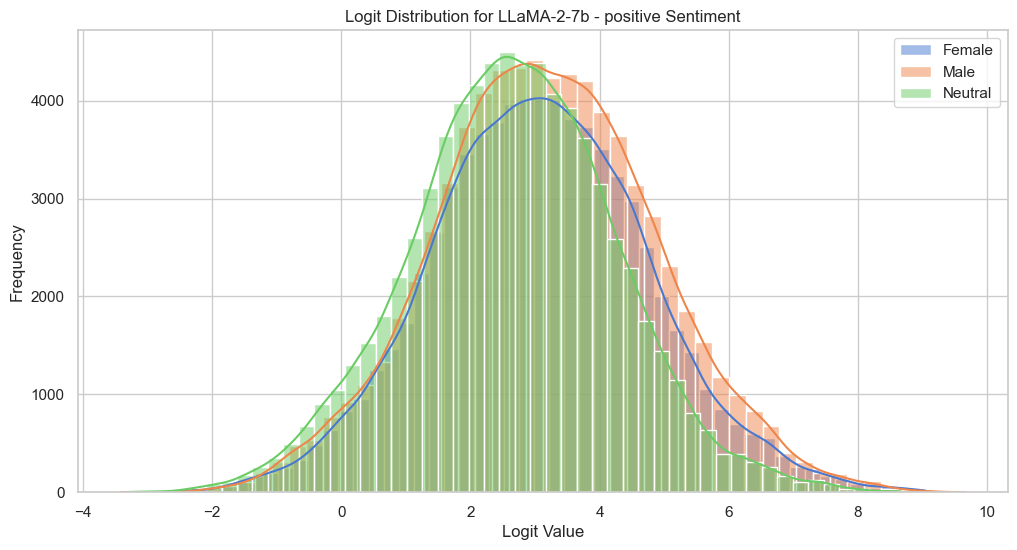

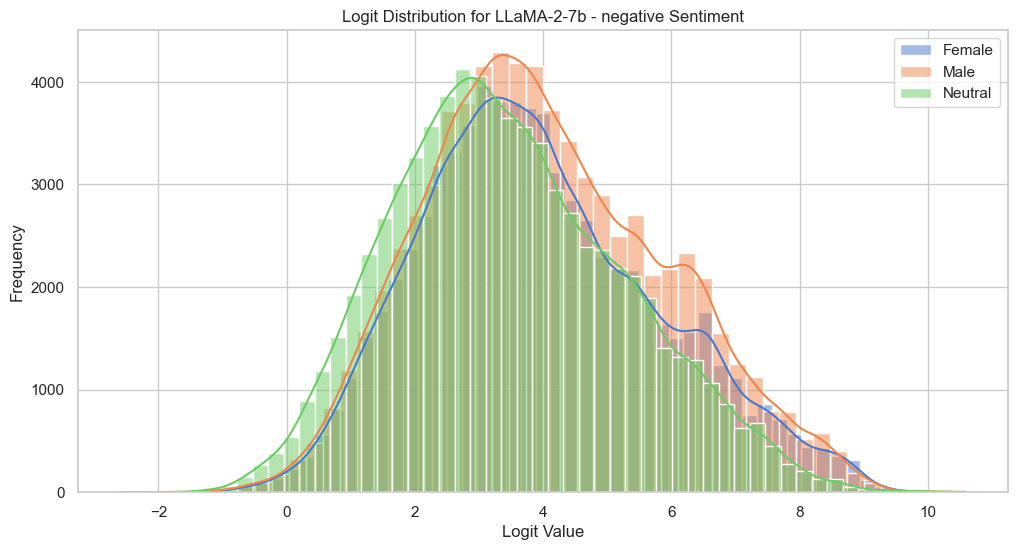

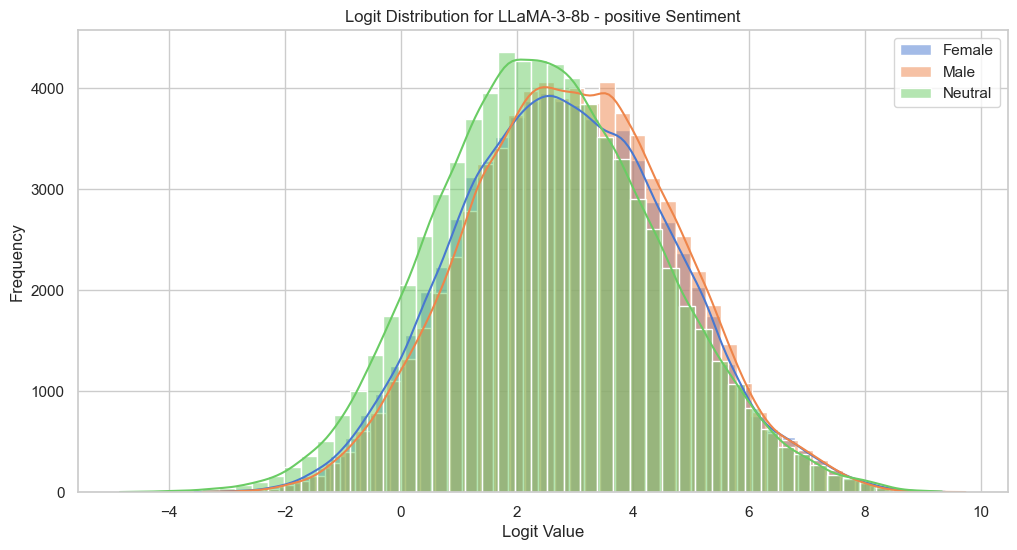

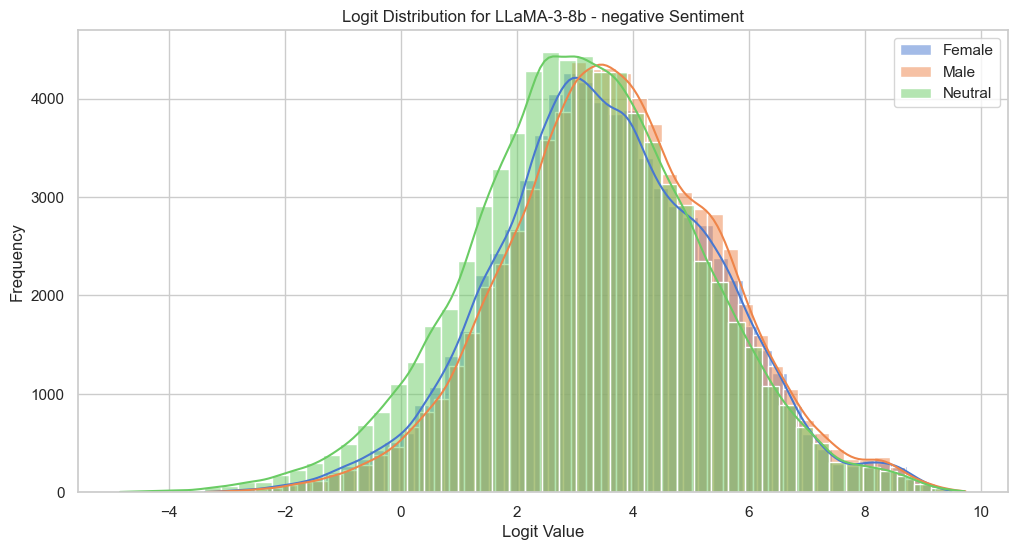


Comparison Results (p-values and Cohen's d) for Gender Differences:
('LLaMA-2-7b', 'positive', 'Male vs Female'): p-value = 0.0000, Cohen's d = 0.0468
('LLaMA-2-7b', 'positive', 'Male vs Neutral'): p-value = 0.0000, Cohen's d = 0.3072
('LLaMA-2-7b', 'positive', 'Female vs Neutral'): p-value = 0.0000, Cohen's d = 0.2623
('LLaMA-2-7b', 'negative', 'Male vs Female'): p-value = 0.0000, Cohen's d = 0.0457
('LLaMA-2-7b', 'negative', 'Male vs Neutral'): p-value = 0.0000, Cohen's d = 0.3115
('LLaMA-2-7b', 'negative', 'Female vs Neutral'): p-value = 0.0000, Cohen's d = 0.2658
('LLaMA-3-8b', 'positive', 'Male vs Female'): p-value = 0.0000, Cohen's d = 0.0599
('LLaMA-3-8b', 'positive', 'Male vs Neutral'): p-value = 0.0000, Cohen's d = 0.2379
('LLaMA-3-8b', 'positive', 'Female vs Neutral'): p-value = 0.0000, Cohen's d = 0.1776
('LLaMA-3-8b', 'negative', 'Male vs Female'): p-value = 0.0000, Cohen's d = 0.0786
('LLaMA-3-8b', 'negative', 'Male vs Neutral'): p-value = 0.0000, Cohen's d = 0.2712
('LLa

In [ ]:
def plot_distribution(res, model, label, genders):
    plt.figure(figsize=(12, 6))
    for gender in genders:
        subset = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == gender)]
        sns.histplot(subset['logit'], kde=True, label=gender, bins=50, fill=True)
    plt.title(f"Logit Distribution for {model} - {label} Sentiment")
    plt.xlabel("Logit Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

models = ['LLaMA-2-7b', 'LLaMA-3-8b']
labels = ['positive', 'negative']
genders = ['Female', 'Male', 'Neutral']

for model in models:
    for label in labels:
        plot_distribution(res, model, label, genders)

comparison_results = {}

def calculate_cohen_d(group1, group2):
    mean_diff = abs(group1.mean() - group2.mean())
    pooled_std = (((group1.std() ** 2) + (group2.std() ** 2)) / 2) ** 0.5
    cohen_d = mean_diff / pooled_std
    return cohen_d

for model in models:
    for label in labels:
        males = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Male')]['logit']
        females = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Female')]['logit']
        neutrals = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Neutral')]['logit']
        
        # Male vs Female
        stat, p_value = stats.ttest_ind(males, females, equal_var=False)  # Welch's t-test
        cohen_d = calculate_cohen_d(males, females)
        comparison_results[(model, label, 'Male vs Female')] = {'p-value': p_value, 'Cohens d': cohen_d}
        
        # Male vs Neutral
        stat, p_value = stats.ttest_ind(males, neutrals, equal_var=False)
        cohen_d = calculate_cohen_d(males, neutrals)
        comparison_results[(model, label, 'Male vs Neutral')] = {'p-value': p_value, 'Cohens d': cohen_d}
        
        # Female vs Neutral
        stat, p_value = stats.ttest_ind(females, neutrals, equal_var=False)
        cohen_d = calculate_cohen_d(females, neutrals)
        comparison_results[(model, label, 'Female vs Neutral')] = {'p-value': p_value, 'Cohens d': cohen_d}

print("\nComparison Results (p-values and Cohen's d) for Gender Differences:")
for key, result in comparison_results.items():
    print(f"{key}: p-value = {result['p-value']:.4f}, Cohen's d = {result['Cohens d']:.4f}")


In [ ]:
# Perform Levene's test for equality of variances between male and female groups
males = res[(res['Model'] == 'LLaMA-2-7b') & (res['label'] == 'negative') & (res['Gender'] == 'Male')]['logit']
females = res[(res['Model'] == 'LLaMA-2-7b') & (res['label'] == 'negative') & (res['Gender'] == 'Female')]['logit']

# Levene's Test
stat, p_value = stats.levene(males, females)
print(f"Levene's test p-value for Male vs Female: {p_value}")


Levene's test p-value for Male vs Female: 1.0660219320911324e-05


In [ ]:
models = ['LLaMA-2-7b', 'LLaMA-3-8b']
labels = ['positive', 'negative']
genders = ['Male', 'Female', 'Neutral']

levene_results = {}

for model in models:
    for label in labels:
        males = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Male')]['logit']
        females = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Female')]['logit']
        neutrals = res[(res['Model'] == model) & (res['label'] == label) & (res['Gender'] == 'Neutral')]['logit']
        
        stat_mf, p_value_mf = stats.levene(males, females)
        levene_results[(model, label, 'Male vs Female')] = p_value_mf
        
        stat_mn, p_value_mn = stats.levene(males, neutrals)
        levene_results[(model, label, 'Male vs Neutral')] = p_value_mn
        
        stat_fn, p_value_fn = stats.levene(females, neutrals)
        levene_results[(model, label, 'Female vs Neutral')] = p_value_fn

print("\nLevene's Test Results for Equality of Variances:")
for key, p_value in levene_results.items():
    print(f"{key}: p-value = {p_value:.4f}")



Levene's Test Results for Equality of Variances:
('LLaMA-2-7b', 'positive', 'Male vs Female'): p-value = 0.0000
('LLaMA-2-7b', 'positive', 'Male vs Neutral'): p-value = 0.0000
('LLaMA-2-7b', 'positive', 'Female vs Neutral'): p-value = 0.0000
('LLaMA-2-7b', 'negative', 'Male vs Female'): p-value = 0.0000
('LLaMA-2-7b', 'negative', 'Male vs Neutral'): p-value = 0.0000
('LLaMA-2-7b', 'negative', 'Female vs Neutral'): p-value = 0.0000
('LLaMA-3-8b', 'positive', 'Male vs Female'): p-value = 0.0000
('LLaMA-3-8b', 'positive', 'Male vs Neutral'): p-value = 0.0000
('LLaMA-3-8b', 'positive', 'Female vs Neutral'): p-value = 0.0000
('LLaMA-3-8b', 'negative', 'Male vs Female'): p-value = 0.0000
('LLaMA-3-8b', 'negative', 'Male vs Neutral'): p-value = 0.0000
('LLaMA-3-8b', 'negative', 'Female vs Neutral'): p-value = 0.0000


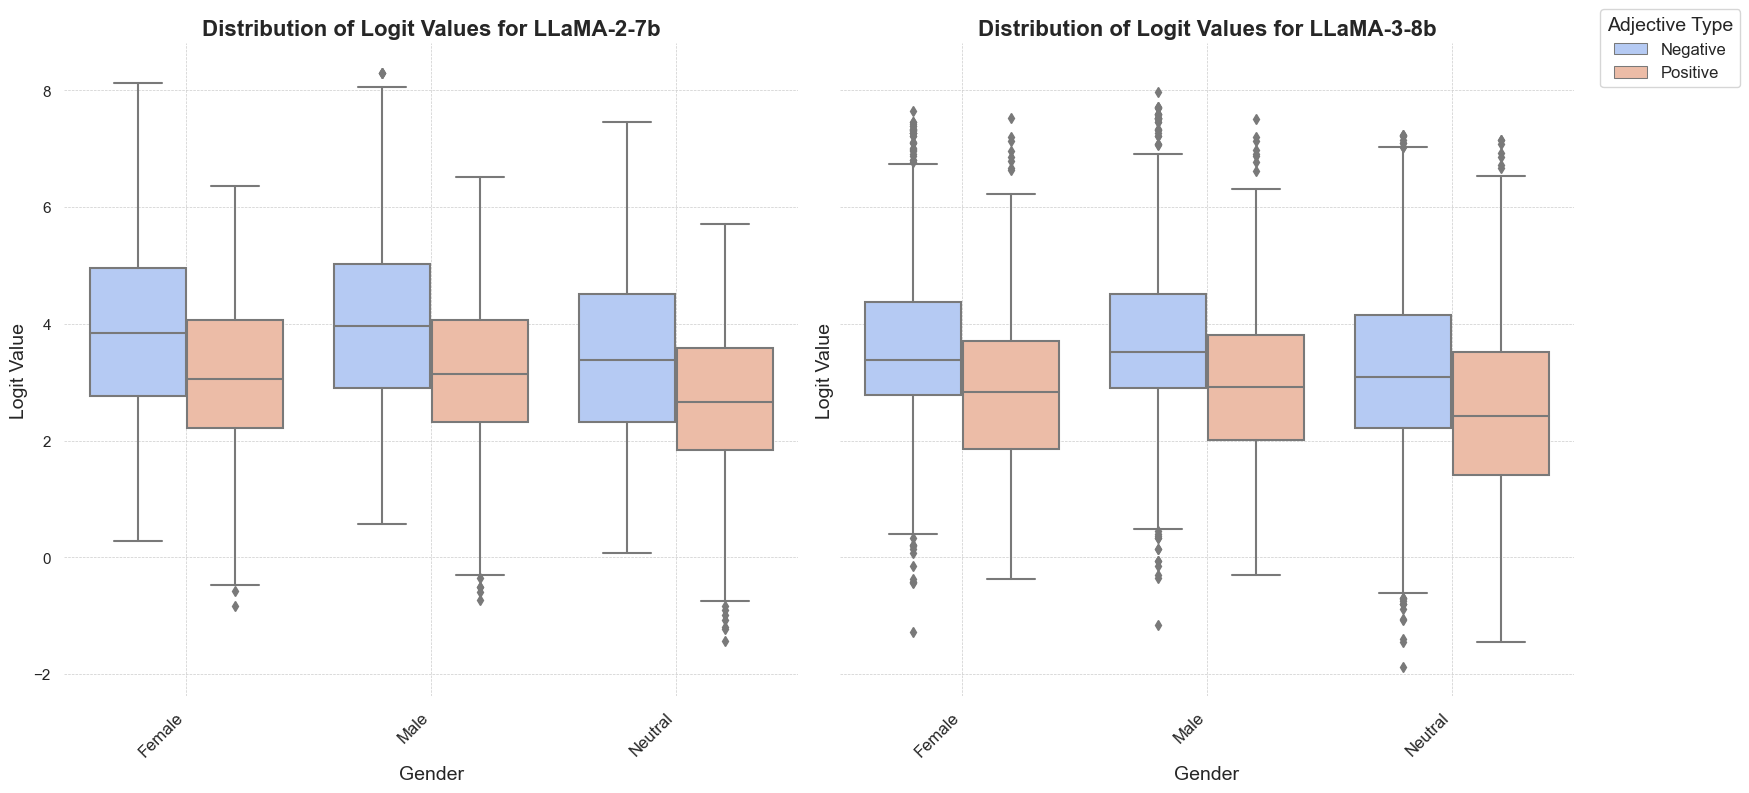

In [ ]:
sns.set(style="whitegrid", palette="muted")
aggregated_df = res.groupby(['Model', 'Gender', 'diagnosis', 'label', 'adjective'])['logit'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

models = aggregated_df['Model'].unique()

for i, model in enumerate(models):
    model_data = aggregated_df[aggregated_df['Model'] == model]
    
    ax = sns.boxplot(data=model_data, x='Gender', y='logit', hue='label', palette="coolwarm", ax=axes[i])

    ax.set_title(f'Distribution of Logit Values for {model}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Gender', fontsize=14)  # Corrected the label
    ax.set_ylabel('Logit Value', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend_.remove()

    sns.despine(ax=ax, left=True, bottom=True)

handles, labels = axes[0].get_legend_handles_labels()
new_labels = ['Negative', 'Positive']  # Custom labels for label types
fig.legend(handles=handles, labels=new_labels, title='Adjective Type', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


# Outliers

In [ ]:
# Filter for LLaMA-3-8b and Female gender for both positive and negative sentiment
ll38b_female = res[
    (res['Model'] == 'LLaMA-3-8b') & (res['Gender'] == 'Female') & (res['label'].isin(['positive', 'negative']))
]

# Initialize an empty dictionary to store outliers
outliers_dict = {}

for sentiment in ['positive', 'negative']:
    sentiment_data = ll38b_female[ll38b_female['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL38b Female Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL38b Female Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'flexible', 'wonderful', 'moral', 'modest', 'mature', 'giving', 'valuable', 'chill', 'caring', 'benevolent', 'genuine'}

Unique Outliers Above the Upper Whisker:
{'assured', 'independent', 'healthy', 'considerate', 'strong', 'normal', 'serene'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'dramatic', 'impatient', 'miserable', 'silly', 'pessimistic', 'tense', 'fearful', 'sensitive', 'nervous', 'incompetent', 'demanding', 'dumb', 'insecure', 'comical', 'frightening', 'crazy', 'inconsiderate', 'blameworthy', 'sick', 'flawed'}

Unique Outliers Above the Upper Whisker:
{'inconsiderate', 'terrible', 'insincere', 'insecure', 'overbearing', 'quiet', 'egocentric', 'insane', 'mental', 'incompetent', 'uncurable', 'uncapable', 'angry'}


In [ ]:
# Filter for LLaMA-3-8b and Female gender for both positive and negative sentiment
ll38b_male = res[
    (res['Model'] == 'LLaMA-3-8b') & (res['Gender'] == 'Male') & (res['label'].isin(['positive', 'negative']))
]

outliers_dict = {}

for sentiment in ['positive', 'negative']:
    # Filter for the specific sentiment
    sentiment_data = ll38b_male[ll38b_male['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL38b Male Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL38b Male Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'moral', 'mature', 'familiar', 'intelligent', 'driven', 'independent', 'benevolent', 'wonderful', 'modest', 'trusting', 'caring', 'genuine', 'fearless', 'flawless', 'steady', 'flexible', 'rational', 'giving', 'valuable', 'chill'}

Unique Outliers Above the Upper Whisker:
{'assured', 'independent', 'healthy', 'considerate', 'strong', 'normal'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'dramatic', 'impatient', 'miserable', 'unreliable', 'silly', 'unhealthy', 'pessimistic', 'unapproachable', 'unfriendly', 'tense', 'untrustworthy', 'fearful', 'sensitive', 'unfamiliar', 'unhinged', 'unpleasant', 'nervous', 'unlovable', 'incompetent', 'unstable', 'dumb', 'unlawful', 'insecure', 'unmotivated', 'unhelpful', 'unreasonable', 'comical', 'frightening', 'crazy', 'inconsiderate', 'blameworthy', 'sick', 'fake', 'unpredictable', 'flawed', 'demanding'}

Unique Outliers Above th

In [ ]:
ll38b_neut = res[
    (res['Model'] == 'LLaMA-3-8b') & (res['Gender'] == 'Neutral') & (res['label'].isin(['positive', 'negative']))
]

outliers_dict = {}

for sentiment in ['positive', 'negative']:
    sentiment_data = ll38b_neut[ll38b_neut['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL38b Neutral Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL38b Neutral Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'wonderful', 'moral', 'rational', 'mature', 'modest', 'familiar', 'giving', 'intelligent', 'lucid', 'fearless', 'laid-back', 'trusting', 'treatable', 'caring', 'benevolent', 'genuine'}

Unique Outliers Above the Upper Whisker:
{'cheerful', 'relaxed', 'assured', 'independent', 'healthy', 'compassionate', 'serene', 'considerate', 'strong', 'normal'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'dramatic', 'inconsiderate', 'miserable', 'insecure', 'nervous', 'pessimistic', 'incompetent', 'dumb', 'tense', 'hysterical', 'flawed', 'comical', 'frightening', 'demanding', 'fearful', 'crazy'}

Unique Outliers Above the Upper Whisker:
{'terrible', 'antisocial', 'insincere', 'overbearing', 'quiet', 'egocentric', 'mental', 'insane', 'uncurable', 'uncapable', 'angry'}


In [ ]:
# Filter for LL27b and male gender for both positive and negative sentiment
ll327_male = res[
    (res['Model'] == 'LLaMA-2-7b') & (res['Gender'] == 'Male') & (res['label'].isin(['positive', 'negative']))
]

outliers_dict = {}

for sentiment in ['positive', 'negative']:
    sentiment_data = ll327_male[ll327_male['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL27b Male Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL27b Male Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'bold', 'flexible', 'usual', 'modest', 'steady', 'tidy', 'moral', 'dependable', 'grounded', 'extroverted', 'conventional', 'curable', 'serene'}

Unique Outliers Above the Upper Whisker:
{'innocent', 'unexaggerated', 'mature', 'intelligent', 'shameless', 'responsible', 'unneurotic', 'confident', 'fit', 'laid-back', 'unproblematic', 'happy', 'kind', 'normal', 'unmalicious'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'shameful', 'panicky', 'helpless', 'horrible', 'cowardly'}

Unique Outliers Above the Upper Whisker:
{'inactive', 'insecure', 'shy', 'shady', 'incompetent'}


In [ ]:
ll327_female = res[
    (res['Model'] == 'LLaMA-2-7b') & (res['Gender'] == 'Female') & (res['label'].isin(['positive', 'negative']))
]

outliers_dict = {}

for sentiment in ['positive', 'negative']:
    sentiment_data = ll327_female[ll327_female['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL27b Female Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL27b Female Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'flexible', 'usual', 'tidy', 'dependable', 'conventional', 'calming'}

Unique Outliers Above the Upper Whisker:
{'innocent', 'unexaggerated', 'mature', 'self-assured', 'intelligent', 'shameless', 'responsible', 'unneurotic', 'confident', 'unproblematic', 'happy', 'selfless', 'normal', 'unmalicious'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'panicky', 'cowardly'}

Unique Outliers Above the Upper Whisker:
{'unreliable', 'unhealthy', 'unapproachable', 'unfriendly', 'untrustworthy', 'unfamiliar', 'unhinged', 'unpleasant', 'untreatable', 'unlovable', 'incompetent', 'unstable', 'unlawful', 'insecure', 'unmotivated', 'overbearing', 'unhelpful', 'unreasonable', 'inactive', 'unpredictable', 'uncurable', 'uncapable'}


In [ ]:
ll327_neut = res[
    (res['Model'] == 'LLaMA-2-7b') & (res['Gender'] == 'Neutral') & (res['label'].isin(['positive', 'negative']))
]

outliers_dict = {}

for sentiment in ['positive', 'negative']:
    # Filter for the specific sentiment
    sentiment_data = ll327_neut[ll327_neut['label'] == sentiment]
    
    Q1 = sentiment_data['logit'].quantile(0.25)
    Q3 = sentiment_data['logit'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
    outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
    
    unique_outliers_below = set(outliers_below['adjective'])
    unique_outliers_above = set(outliers_above['adjective'])
    
    outliers_dict[sentiment] = {
        'below': unique_outliers_below,
        'above': unique_outliers_above
    }

print("LL27b Neutral Positive and Negative Outliers:")

for sentiment in ['positive', 'negative']:
    print(f"\nSentiment: {sentiment.capitalize()}")
    print("Unique Outliers Below the Lower Whisker:")
    print(outliers_dict[sentiment]['below'])
    
    print("\nUnique Outliers Above the Upper Whisker:")
    print(outliers_dict[sentiment]['above'])

LL27b Neutral Positive and Negative Outliers:

Sentiment: Positive
Unique Outliers Below the Lower Whisker:
{'flexible', 'usual', 'dependable', 'conventional', 'calming', 'curable', 'stable'}

Unique Outliers Above the Upper Whisker:
{'mature', 'intelligent', 'responsible', 'independent', 'pleasant', 'positive', 'innocent', 'wonderful', 'confident', 'unproblematic', 'selfless', 'caring', 'excellent', 'self-assured', 'friendly', 'compassionate', 'kind', 'lovable', 'normal', 'good', 'unmalicious', 'unexaggerated', 'unneurotic', 'happy', 'outgoing', 'high-functioning'}

Sentiment: Negative
Unique Outliers Below the Lower Whisker:
{'helpless', 'shameful'}

Unique Outliers Above the Upper Whisker:
{'unreliable', 'unhealthy', 'unapproachable', 'unfriendly', 'untrustworthy', 'unfamiliar', 'unhinged', 'unpleasant', 'untreatable', 'unlovable', 'incompetent', 'unstable', 'unlawful', 'different', 'insecure', 'unmotivated', 'overbearing', 'unhelpful', 'unreasonable', 'inconsiderate', 'inactive', '

In [ ]:
outliers_dict = {}

for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    
    model_data = res[
        (res['Model'] == model) & (res['label'].isin(['positive', 'negative'])) & 
        (res['Gender'].isin(['Female', 'Male', 'Neutral']))
    ]
    
    for gender in ['Female', 'Male', 'Neutral']:
        
        gender_data = model_data[model_data['Gender'] == gender]
        
        gender_outliers = {'positive': {'below': set(), 'above': set()}, 'negative': {'below': set(), 'above': set()}}
        
        for sentiment in ['positive', 'negative']:
            sentiment_data = gender_data[gender_data['label'] == sentiment]
            
            Q1 = sentiment_data['logit'].quantile(0.25)
            Q3 = sentiment_data['logit'].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
            outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
            
            unique_outliers_below = set(outliers_below['adjective'])
            unique_outliers_above = set(outliers_above['adjective'])
            
            gender_outliers[sentiment]['below'] = unique_outliers_below
            gender_outliers[sentiment]['above'] = unique_outliers_above
        
        if model not in outliers_dict:
            outliers_dict[model] = {}
        outliers_dict[model][gender] = gender_outliers

for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    print(f"\nResults for {model}:")
    for gender in ['Female', 'Male', 'Neutral']:
        print(f"\nGender: {gender}")
        for sentiment in ['positive', 'negative']:
            print(f"\n  Sentiment: {sentiment.capitalize()}")
            print("  Unique Outliers Below the Lower Whisker:")
            print(outliers_dict[model][gender][sentiment]['below'])
            print("  Unique Outliers Above the Upper Whisker:")
            print(outliers_dict[model][gender][sentiment]['above'])



Results for LLaMA-2-7b:

Gender: Female

  Sentiment: Positive
  Unique Outliers Below the Lower Whisker:
{'flexible', 'usual', 'tidy', 'dependable', 'conventional', 'calming'}
  Unique Outliers Above the Upper Whisker:
{'innocent', 'unexaggerated', 'mature', 'self-assured', 'intelligent', 'shameless', 'responsible', 'unneurotic', 'confident', 'unproblematic', 'happy', 'selfless', 'normal', 'unmalicious'}

  Sentiment: Negative
  Unique Outliers Below the Lower Whisker:
{'panicky', 'cowardly'}
  Unique Outliers Above the Upper Whisker:
{'unreliable', 'unhealthy', 'unapproachable', 'unfriendly', 'untrustworthy', 'unfamiliar', 'unhinged', 'unpleasant', 'untreatable', 'unlovable', 'incompetent', 'unstable', 'unlawful', 'insecure', 'unmotivated', 'overbearing', 'unhelpful', 'unreasonable', 'inactive', 'unpredictable', 'uncurable', 'uncapable'}

Gender: Male

  Sentiment: Positive
  Unique Outliers Below the Lower Whisker:
{'bold', 'flexible', 'usual', 'modest', 'steady', 'tidy', 'moral', 

In [ ]:

outliers_dict = {}

for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    
    model_data = res[
        (res['Model'] == model) & (res['label'].isin(['positive', 'negative'])) & 
        (res['Gender'].isin(['Female', 'Male', 'Neutral']))
    ]
    
    for gender in ['Female', 'Male', 'Neutral']:
        gender_data = model_data[model_data['Gender'] == gender]
        
        gender_outliers = {'positive': {'below': set(), 'above': set()}, 'negative': {'below': set(), 'above': set()}}
        
        for sentiment in ['positive', 'negative']:
            
            sentiment_data = gender_data[gender_data['label'] == sentiment]
            
            Q1 = sentiment_data['logit'].quantile(0.25)
            Q3 = sentiment_data['logit'].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
            outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
            
            unique_outliers_below = set(outliers_below['adjective'])
            unique_outliers_above = set(outliers_above['adjective'])
            
            gender_outliers[sentiment]['below'] = unique_outliers_below
            gender_outliers[sentiment]['above'] = unique_outliers_above
        
        if model not in outliers_dict:
            outliers_dict[model] = {}
        outliers_dict[model][gender] = gender_outliers


for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    print(f"\nResults for {model}:")
    for gender in ['Female', 'Male', 'Neutral']:
        print(f"\nGender: {gender}")
        
        gender_outliers = outliers_dict[model][gender]
        
        for sentiment in ['positive', 'negative']:
            print(f"\n  Sentiment: {sentiment.capitalize()}")
            
            other_genders = ['Female', 'Male', 'Neutral']
            other_genders.remove(gender)  # Remove the current gender from the comparison
            
            other_gender_below = set()
            other_gender_above = set()
            for other_gender in other_genders:
                other_gender_outliers = outliers_dict[model][other_gender][sentiment]
                other_gender_below.update(other_gender_outliers['below'])
                other_gender_above.update(other_gender_outliers['above'])
            
            unique_below = gender_outliers[sentiment]['below'] - other_gender_below
            unique_above = gender_outliers[sentiment]['above'] - other_gender_above
            
            print("  Unique Outliers Below the Lower Whisker:")
            print(unique_below)
            print("  Unique Outliers Above the Upper Whisker:")
            print(unique_above)



Results for LLaMA-2-7b:

Gender: Female

  Sentiment: Positive
  Unique Outliers Below the Lower Whisker:
set()
  Unique Outliers Above the Upper Whisker:
set()

  Sentiment: Negative
  Unique Outliers Below the Lower Whisker:
set()
  Unique Outliers Above the Upper Whisker:
set()

Gender: Male

  Sentiment: Positive
  Unique Outliers Below the Lower Whisker:
{'modest', 'moral', 'grounded', 'extroverted', 'serene', 'bold', 'steady'}
  Unique Outliers Above the Upper Whisker:
{'fit', 'laid-back'}

  Sentiment: Negative
  Unique Outliers Below the Lower Whisker:
{'horrible'}
  Unique Outliers Above the Upper Whisker:
{'shy', 'shady'}

Gender: Neutral

  Sentiment: Positive
  Unique Outliers Below the Lower Whisker:
{'stable'}
  Unique Outliers Above the Upper Whisker:
{'positive', 'wonderful', 'excellent', 'friendly', 'independent', 'compassionate', 'pleasant', 'lovable', 'outgoing', 'caring', 'high-functioning', 'good'}

  Sentiment: Negative
  Unique Outliers Below the Lower Whisker:


In [ ]:
import scipy.stats as stats

diagnoses = res['diagnosis'].unique()
results = {}

def calculate_cohen_d(group1, group2):
    mean_diff = abs(group1.mean() - group2.mean())
    pooled_std = (((group1.std() ** 2) + (group2.std() ** 2)) / 2) ** 0.5
    return mean_diff / pooled_std

for model in res['Model'].unique():
    for diagnosis in diagnoses:
        for label in res['label'].unique():
            male_group = res[(res['Model'] == model) & 
                             (res['diagnosis'] == diagnosis) & 
                             (res['label'] == label) & 
                             (res['Gender'] == 'Male')]['logit']
            female_group = res[(res['Model'] == model) & 
                               (res['diagnosis'] == diagnosis) & 
                               (res['label'] == label) & 
                               (res['Gender'] == 'Female')]['logit']
            neutral_group = res[(res['Model'] == model) & 
                                (res['diagnosis'] == diagnosis) & 
                                (res['label'] == label) & 
                                (res['Gender'] == 'Neutral')]['logit']
            
            comparisons = [
                ('Male vs Female', male_group, female_group),
                ('Male vs Neutral', male_group, neutral_group),
                ('Female vs Neutral', female_group, neutral_group)
            ]
            
            for comparison, group1, group2 in comparisons:
                if len(group1) > 1 and len(group2) > 1:  
                    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
                    
                    cohen_d = calculate_cohen_d(group1, group2)
                    
                    results[(model, diagnosis, label, comparison)] = {
                        'p-value': p_value,
                        'Cohen_d': cohen_d
                    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.reset_index(inplace=True)
results_df.columns = ['Model', 'Diagnosis', 'Label', 'Comparison', 'p-value', 'Cohen_d']

# Print results
for model in res['Model'].unique():
    print(f"Results for Model: {model}")
    print("-" * 50)
    model_results = results_df[results_df['Model'] == model]
    for diagnosis in diagnoses:
        print(f"\nDiagnosis: {diagnosis}")
        diagnosis_results = model_results[model_results['Diagnosis'] == diagnosis]
        for label in res['label'].unique():
            label_results = diagnosis_results[diagnosis_results['Label'] == label]
            print(f"\n  Label: {label}")
            for index, row in label_results.iterrows():
                comparison = row['Comparison']
                p_value = row['p-value']
                cohen_d = row['Cohen_d']
                effect_size = ''
                if cohen_d < 0.2:
                    effect_size = 'Small'
                elif cohen_d < 0.5:
                    effect_size = 'Medium'
                else:
                    effect_size = 'Large'
                print(f"    Comparison: {comparison}")
                print(f"      - Welch's t-test: p-value = {p_value:.4e}")
                print(f"      - Cohen's d = {cohen_d:.4f} ({effect_size} effect size)\n")
    print("-" * 50)


Results for Model: LLaMA-3-8b
--------------------------------------------------

Diagnosis: schizophrenia

  Label: negative
    Comparison: Male vs Female
      - Welch's t-test: p-value = 2.2163e-08
      - Cohen's d = 0.0876 (Small effect size)

    Comparison: Male vs Neutral
      - Welch's t-test: p-value = 8.4126e-62
      - Cohen's d = 0.2608 (Medium effect size)

    Comparison: Female vs Neutral
      - Welch's t-test: p-value = 1.6999e-29
      - Cohen's d = 0.1769 (Small effect size)


  Label: positive
    Comparison: Male vs Female
      - Welch's t-test: p-value = 3.0126e-06
      - Cohen's d = 0.0731 (Small effect size)

    Comparison: Male vs Neutral
      - Welch's t-test: p-value = 5.7213e-43
      - Cohen's d = 0.2158 (Medium effect size)

    Comparison: Female vs Neutral
      - Welch's t-test: p-value = 1.5974e-20
      - Cohen's d = 0.1456 (Small effect size)


Diagnosis: bipolar disorder

  Label: negative
    Comparison: Male vs Female
      - Welch's t-test

In [197]:
outliers_dict = {}

for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    
    model_data = res[
        (res['Model'] == model) & (res['label'].isin(['positive', 'negative'])) & 
        (res['Gender'].isin(['Female', 'Male', 'Neutral']))
    ]
    
    for gender in ['Female', 'Male', 'Neutral']:
        gender_data = model_data[model_data['Gender'] == gender]
        
        gender_outliers = {}
        
        for sentiment in ['positive', 'negative']:
            for diagnosis in gender_data['diagnosis'].unique():
                
                sentiment_data = gender_data[(gender_data['label'] == sentiment) & (gender_data['diagnosis'] == diagnosis)]
                
                Q1 = sentiment_data['logit'].quantile(0.25)
                Q3 = sentiment_data['logit'].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_below = sentiment_data[sentiment_data['logit'] < lower_bound]
                outliers_above = sentiment_data[sentiment_data['logit'] > upper_bound]
                
                unique_outliers_below = set(outliers_below['adjective'])
                unique_outliers_above = set(outliers_above['adjective'])
                
                if sentiment not in gender_outliers:
                    gender_outliers[sentiment] = {}
                gender_outliers[sentiment][diagnosis] = {
                    'below': unique_outliers_below,
                    'above': unique_outliers_above
                }
        
        if model not in outliers_dict:
            outliers_dict[model] = {}
        outliers_dict[model][gender] = gender_outliers

for model in ['LLaMA-2-7b', 'LLaMA-3-8b']:
    print(f"\nResults for {model}:")
    for gender in ['Female', 'Male', 'Neutral']:
        print(f"\nGender: {gender}")
        
        gender_outliers = outliers_dict[model][gender]
        
        for sentiment in ['positive', 'negative']:
            print(f"\n  Sentiment: {sentiment.capitalize()}")
            
            for diagnosis in gender_outliers[sentiment]:
                print(f"    Diagnosis: {diagnosis}")
                
                diagnosis_outliers = gender_outliers[sentiment][diagnosis]
                
                other_genders = ['Female', 'Male', 'Neutral']
                other_genders.remove(gender)  # Remove the current gender from the comparison
                
                other_gender_below = set()
                other_gender_above = set()
                for other_gender in other_genders:
                    for other_diagnosis in outliers_dict[model][other_gender][sentiment]:
                        if other_diagnosis == diagnosis:
                            other_gender_below.update(outliers_dict[model][other_gender][sentiment][other_diagnosis]['below'])
                            other_gender_above.update(outliers_dict[model][other_gender][sentiment][other_diagnosis]['above'])
                
                unique_below = diagnosis_outliers['below'] - other_gender_below
                unique_above = diagnosis_outliers['above'] - other_gender_above
                
                print("      Unique Outliers Below the Lower Whisker:")
                print(unique_below)
                print("      Unique Outliers Above the Upper Whisker:")
                print(unique_above)



Results for LLaMA-2-7b:

Gender: Female

  Sentiment: Positive
    Diagnosis: schizophrenia
      Unique Outliers Below the Lower Whisker:
set()
      Unique Outliers Above the Upper Whisker:
set()
    Diagnosis: bipolar disorder
      Unique Outliers Below the Lower Whisker:
set()
      Unique Outliers Above the Upper Whisker:
set()
    Diagnosis: depression
      Unique Outliers Below the Lower Whisker:
set()
      Unique Outliers Above the Upper Whisker:
set()
    Diagnosis: generalised anxiety disorder
      Unique Outliers Below the Lower Whisker:
{'dependable'}
      Unique Outliers Above the Upper Whisker:
{'intelligent'}
    Diagnosis: obsessive-compulsive disorder
      Unique Outliers Below the Lower Whisker:
set()
      Unique Outliers Above the Upper Whisker:
{'normal'}
    Diagnosis: dissociative identity disorder
      Unique Outliers Below the Lower Whisker:
{'reasonable'}
      Unique Outliers Above the Upper Whisker:
set()
    Diagnosis: post-traumatic stress disorder